# <center> Сегментация клиентов онлайн магазина подарков


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности (Monetary), частоты заказов (Frequency) и срока давности последней покупки (Recency), определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Предобработка данных о транзакциях
2. Разведывательный анализ данных
3. Формирование RFM-характеристик клиентов
4. Построение и сравнение моделей кластеризации
5. Интерпретация полученных сегментов

> Подробное описание проекта и результаты см. в [README](../README.md)


Импорт базовых библиотек:

In [2]:
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import kaleido

import warnings
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

from scipy import stats
from scipy.stats import shapiro, jarque_bera, normaltest
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True


## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:

* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнайте, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнайте, из каких стран совершались транзакции.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

In [4]:
data = pd.read_csv(
    "data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [5]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  str    
 7   Country      541909 non-null  str    
dtypes: float64(1), int64(1), str(6)
memory usage: 33.1 MB


In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


In [7]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  str           
 1   StockCode    541909 non-null  str           
 2   Description  540455 non-null  str           
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[us]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  str           
 7   Country      541909 non-null  str           
dtypes: datetime64[us](1), float64(1), int64(1), str(5)
memory usage: 33.1 MB


In [8]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [9]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


In [10]:
unique_customers = data['CustomerID'].nunique()
total_transactions = len(data)
print('Количество уникальных клиентов:', unique_customers)
print('Общее количество транзакций:', total_transactions)
print('Среднее количество транзакций на клиента:', (total_transactions / unique_customers).__round__(0))


Количество уникальных клиентов: 4372
Общее количество транзакций: 541909
Среднее количество транзакций на клиента: 124.0


In [11]:
countries = data['Country'].value_counts()
print('Количество уникальных стран:', len(countries))
print('ТОП-10 стран по количеству транзакций:', countries.head(10))


Количество уникальных стран: 38
ТОП-10 стран по количеству транзакций: Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64


In [12]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
data.duplicated().sum()

np.int64(5268)

In [14]:
data.dtypes

InvoiceNo                 str
StockCode                 str
Description               str
Quantity                int64
InvoiceDate    datetime64[us]
UnitPrice             float64
CustomerID                str
Country                   str
dtype: object

In [15]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалите их из данных.

**Примечание.** Если посмотреть на распределение пропусков в столбцах Description и CustomerID, то можно заметить, что достаточно удалить строки, содержащие пропуски в столбце CustomerID, тогда пропуски в столбце Description удаляются автоматически.


In [16]:
print("Пропуски до очистки:", data.isnull().sum().sum())
data = data.dropna(subset=['CustomerID'])
print("Пропуски после очистки:", data.isnull().sum().sum())
print("Размер после удаления пропусков CustomerID:", data.shape)

Пропуски до очистки: 136534
Пропуски после очистки: 0
Размер после удаления пропусков CustomerID: (406829, 8)


In [17]:
data['Description'].isnull().sum()

np.int64(0)

#### 2.1.2. Дубликаты

Проверьте данные на наличие дубликатов. Удалите их из данных.


In [18]:
print("Дубликатов найдено:", data.duplicated().sum())
data = data.drop_duplicates()
print("Размер после удаления дубликатов:", data.shape)

Дубликатов найдено: 5225
Размер после удаления дубликатов: (401604, 8)


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [19]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


**Примечание.** Более 16 % уникальных заказов являются возвратами. Интересный факт: если мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

Создайте в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

В качестве вспомогательного инструмента мы подготовили для вас функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). При желании вы можете самостоятельно модифицировать функцию для предобработки, чтобы учесть этот пограничный случай.

*Осторожно! Поиск отменённых транзакций занимает много времени из-за большого количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от мощности компьютера.*

In [20]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

In [21]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0


In [22]:
data.dtypes

InvoiceNo                      str
StockCode                      str
Description                    str
Quantity                     int64
InvoiceDate         datetime64[us]
UnitPrice                  float64
CustomerID                     str
Country                        str
QuantityCanceled           float64
dtype: object

*Осторожно! Поиск отмененных транзакций занимает достаточно длительное время из-за количества строк в таблице. Выполнение следующего кода может занять до 20 минут в зависимости от компьютера.*

Узнайте, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалите их из данных.

Когда вы разобрались с возвратами, удалите транзакции с отрицательным количеством товара — они нам больше не нужны.



In [23]:
data_copy = data.copy()

In [24]:
data.shape

(401604, 9)

In [25]:
data[data['QuantityCanceled'].isna()].shape

(1303, 9)

In [26]:
# Удаляем все строки, где QuantityCanceled содержит NaN
data = data.dropna(subset=['QuantityCanceled'])
data.shape

(400301, 9)

In [27]:
# Удаляем все строки, где Quantity < 0
minus_quantity = data[data['Quantity']<0]
minus_quantity.shape

(7569, 9)

In [28]:
data = data.drop(minus_quantity.index)
data.shape

(392732, 9)

In [29]:
data.dtypes

InvoiceNo                      str
StockCode                      str
Description                    str
Quantity                     int64
InvoiceDate         datetime64[us]
UnitPrice                  float64
CustomerID                     str
Country                        str
QuantityCanceled           float64
dtype: object

In [30]:
# Преобразуем тип данных InvoiceNo в целые числа
data['InvoiceNo'] = data['InvoiceNo'].astype(int)

#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

**Подсказка.** В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'.

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы.

In [31]:
# Находим коды товаров, начинающиеся с латинских букв
special_transactions = data[data['StockCode'].str.contains(r'^[a-zA-Z]', na=False)]
special_transactions.shape

(1549, 9)

In [32]:
data = data.drop(special_transactions.index)
data.shape

(391183, 9)

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [33]:
zero_price = data[data['UnitPrice'] == 0]
zero_price.shape

(33, 9)

In [34]:
data = data.drop(zero_price.index)
data.shape

(391150, 9)

#### 2.1.6. Общая стоимость товаров в транзакции

Добавьте в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [35]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

In [36]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00


In [37]:
data.shape

(391150, 10)

In [38]:
data.dtypes

InvoiceNo                    int64
StockCode                      str
Description                    str
Quantity                     int64
InvoiceDate         datetime64[us]
UnitPrice                  float64
CustomerID                     str
Country                        str
QuantityCanceled           float64
TotalPrice                 float64
dtype: object

In [39]:
data.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,QuantityCanceled,TotalPrice
count,391150.000000,391150.000000,391150,391150.000000,391150.000000,391150.000000
mean,560592.908268,13.145300,2011-07-10 19:37:34.766714,2.874372,0.626622,21.126404
min,536365.000000,1.000000,2010-12-01 08:26:00,0.040000,0.000000,-81.000000
25%,549235.000000,2.000000,2011-04-07 11:16:00,1.250000,0.000000,4.680000
50%,561875.000000,6.000000,2011-07-31 12:05:00,1.950000,0.000000,11.700000
75%,572062.000000,12.000000,2011-10-20 12:57:00,3.750000,0.000000,19.500000
max,581587.000000,80995.000000,2011-12-09 12:50:00,649.500000,80995.000000,7144.720000
std,13087.235691,180.807831,NaN,4.284738,175.909659,67.823746


#### 2.1.7. Отрицательная общая стоимость товаров в транзакции

В DataFrame обнаружены наблюдения, где количество возвращенных товаров превышает количество заказанных товаров.
При этом:
- доля таких наблюдений составляет менее 1% от общего числа покупателей;
- данные случаи не содержат значимой информации для улучшения качества кластеризации.

Учитывая незначительность выборки и отсутствие практической ценности для анализа, можно удалить эти наблюдения из датасета.

In [40]:
minus_total = data[data['TotalPrice']<0]
minus_total.shape

(36, 10)

In [41]:
data = data.drop(minus_total.index)
data.shape

(391114, 10)

In [42]:
data.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,QuantityCanceled,TotalPrice
count,391114.000000,391114.000000,391114,391114.000000,391114.000000,391114.000000
mean,560593.927175,13.145914,2011-07-10 19:50:43.055937,2.874298,0.625299,21.129871
min,536365.000000,1.000000,2010-12-01 08:26:00,0.040000,0.000000,0.000000
25%,549235.000000,2.000000,2011-04-07 11:16:00,1.250000,0.000000,4.680000
50%,561876.000000,6.000000,2011-07-31 12:08:00,1.950000,0.000000,11.700000
75%,572063.000000,12.000000,2011-10-20 12:57:00,3.750000,0.000000,19.500000
max,581587.000000,80995.000000,2011-12-09 12:50:00,649.500000,80995.000000,7144.720000
std,13086.891492,180.816125,NaN,4.284815,175.917605,67.825691


In [43]:
data.dtypes

InvoiceNo                    int64
StockCode                      str
Description                    str
Quantity                     int64
InvoiceDate         datetime64[us]
UnitPrice                  float64
CustomerID                     str
Country                        str
QuantityCanceled           float64
TotalPrice                 float64
dtype: object

In [44]:
# Преобразуем тип данных CustomerID в целые числа
data['CustomerID'] = data['CustomerID'].astype(int)

In [45]:
data.to_csv(
    'data_clean_final.csv',
    index=False,
    encoding='utf-8',
    sep=',',
    date_format='%d-%m-%Y %H:%M:%S'  
)

Помимо рекомендованных преобразований, вы также можете придумать собственные и применить их к исходным данным.
После завершения предобработки сохраните результат очищения данных в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.


### 2.2. Разведывательный анализ

После предобработки исходных данных произведите разведывательный анализ и исследуйте транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

**Примечание.** Вы можете сформулировать и другие вопросы. Главная цель — извлечь максимум понятной информации из исходных данных.

Свои рассуждения сопроводите графиками и диаграммами.



In [46]:
# # Чтение предобработанных данных из файла
# data = pd.read_csv(
#     'data_clean_final.csv',
#     encoding='utf-8', 
#     sep=',',
#     parse_dates=['InvoiceDate'],
#     dayfirst=True
# )


In [47]:
data.info()

<class 'pandas.DataFrame'>
Index: 391114 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391114 non-null  int64         
 1   StockCode         391114 non-null  str           
 2   Description       391114 non-null  str           
 3   Quantity          391114 non-null  int64         
 4   InvoiceDate       391114 non-null  datetime64[us]
 5   UnitPrice         391114 non-null  float64       
 6   CustomerID        391114 non-null  int64         
 7   Country           391114 non-null  str           
 8   QuantityCanceled  391114 non-null  float64       
 9   TotalPrice        391114 non-null  float64       
dtypes: datetime64[us](1), float64(3), int64(3), str(3)
memory usage: 32.8 MB


In [48]:
data.shape

(391114, 10)

In [49]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


In [50]:
data.dtypes

InvoiceNo                    int64
StockCode                      str
Description                    str
Quantity                     int64
InvoiceDate         datetime64[us]
UnitPrice                  float64
CustomerID                   int64
Country                        str
QuantityCanceled           float64
TotalPrice                 float64
dtype: object

In [51]:
data.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,QuantityCanceled,TotalPrice
count,391114.000000,391114.000000,391114,391114.000000,391114.000000,391114.000000,391114.000000
mean,560593.927175,13.145914,2011-07-10 19:50:43.055937,2.874298,15295.199195,0.625299,21.129871
min,536365.000000,1.000000,2010-12-01 08:26:00,0.040000,12346.000000,0.000000,0.000000
25%,549235.000000,2.000000,2011-04-07 11:16:00,1.250000,13969.000000,0.000000,4.680000
50%,561876.000000,6.000000,2011-07-31 12:08:00,1.950000,15159.000000,0.000000,11.700000
75%,572063.000000,12.000000,2011-10-20 12:57:00,3.750000,16794.000000,0.000000,19.500000
max,581587.000000,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000,80995.000000,7144.720000
std,13086.891492,180.816125,NaN,4.284815,1710.362171,175.917605,67.825691


# Клиенты из каких стран покупают больше и чаще?

In [52]:
# Клиенты из каких стран покупают больше и чаще?

# Группировка по странам + доход
country_data = data.groupby(['Country']).agg({
    'TotalPrice': 'sum',            # Выручка 
    'InvoiceNo': 'nunique',         # Заказы  
    'Quantity': 'sum'               # Количество товаров
}).reset_index()

# переименование колонок 
country_data.columns = ['Country', 'Revenue', 'Orders', 'Quantity']

# Сортировка по выручке
country_data = country_data.sort_values('Revenue', ascending=False)

print("Группировка по странам:")
display(country_data.head(10))

Группировка по странам:


,Country,Revenue,Orders,Quantity
35,United Kingdom,6798228.00,16579,4234095
23,Netherlands,283443.54,93,200258
10,EIRE,247074.57,256,140033
14,Germany,201533.46,443,118031
13,France,181575.68,379,110579
0,Australia,136950.25,56,83890
32,Switzerland,51863.75,47,29980
30,Spain,51764.90,88,27724
3,Belgium,36673.04,98,22962
31,Sweden,36362.91,34,36037


In [53]:
# Топ-10 стран
top10 = country_data.head(10)

# Общие суммы
total_revenue = data['TotalPrice'].sum()
total_orders = data['InvoiceNo'].nunique()
total_quantity = data['Quantity'].sum()

In [54]:
top10

,Country,Revenue,Orders,Quantity
35,United Kingdom,6798228.00,16579,4234095
23,Netherlands,283443.54,93,200258
10,EIRE,247074.57,256,140033
14,Germany,201533.46,443,118031
13,France,181575.68,379,110579
0,Australia,136950.25,56,83890
32,Switzerland,51863.75,47,29980
30,Spain,51764.90,88,27724
3,Belgium,36673.04,98,22962
31,Sweden,36362.91,34,36037


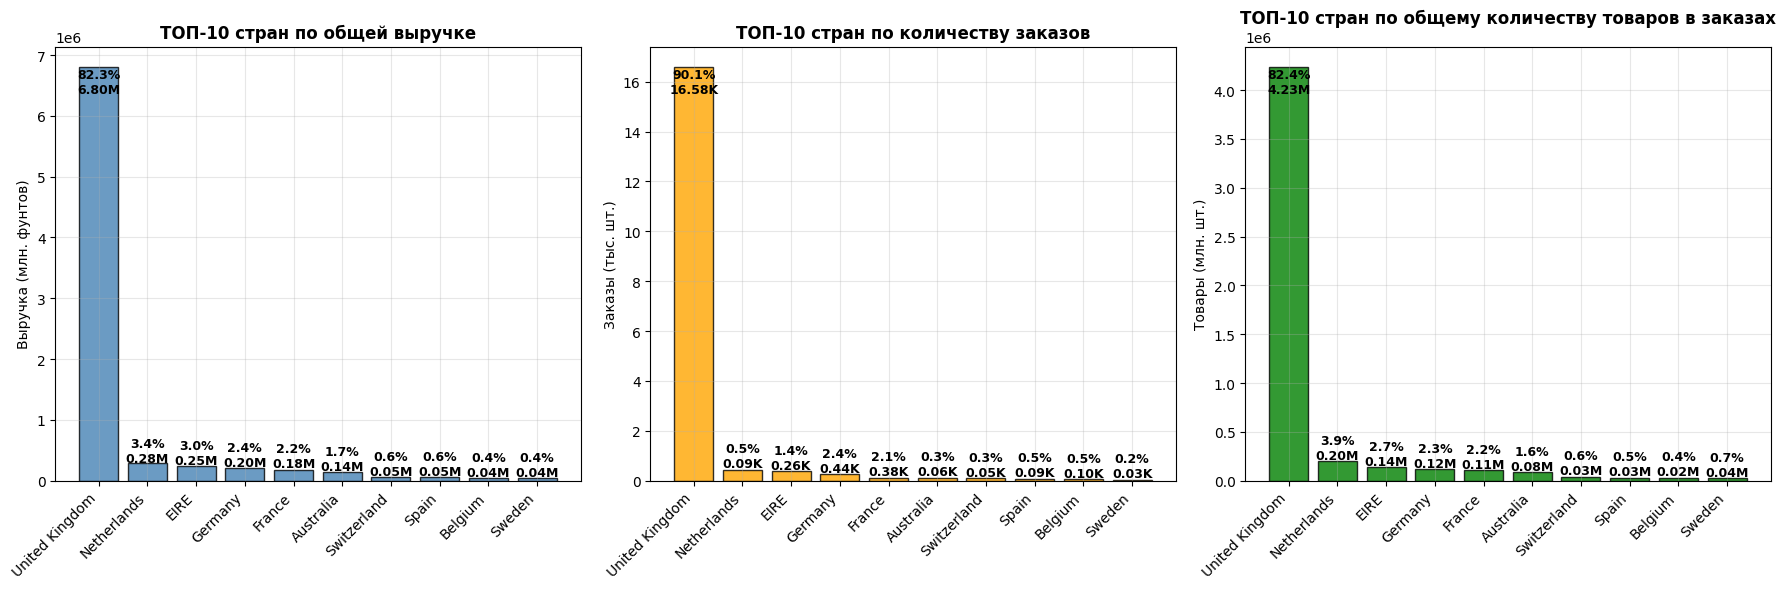

In [108]:
# Графики 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
metrics = [('Revenue', 'Выручка (млн. фунтов)', 'млн. фунтов', total_revenue), 
          ('Orders', 'Заказы (тыс. шт.)', 'тыс. шт.', total_orders), 
          ('Quantity', 'Товары (млн. шт.)', 'млн. шт.', total_quantity)]
colors = ['steelblue', 'orange', 'green']

for i, (metric, title, unit, total) in enumerate(metrics):
    # Делим на 1000 для Orders
    values = top10[metric].sort_values(ascending=False) / 1000 if metric == 'Orders' else top10[metric].sort_values(ascending=False)
    bars = axes[i].bar(range(len(top10)), values, color=colors[i], alpha=0.8)
    
    # заголовки
    if metric == 'Revenue':
        axes[i].set_title('ТОП-10 стран по общей выручке', fontweight='bold')
    elif metric == 'Orders':
        axes[i].set_title('ТОП-10 стран по количеству заказов', fontweight='bold')
    else:
        axes[i].set_title('ТОП-10 стран по общему количеству товаров в заказах', fontweight='bold')
    
    axes[i].set_xticks(range(len(top10)))
    axes[i].set_xticklabels(top10['Country'], rotation=45, ha='right')
    axes[i].set_ylabel(title)
    axes[i].grid(True, alpha=0.3)
    
    # Проценты на столбцах 
    for bar, value in zip(bars, top10[metric]):
        if metric == 'Revenue':
            percentage = (value / total_revenue) * 100
            formatted_value = f'{value/1000000:.2f}M'
        elif metric == 'Orders':
            percentage = (value / total_orders) * 100
            formatted_value = f'{value/1000:.2f}K'
        else:  
            percentage = (value / total_quantity) * 100
            formatted_value = f'{value/1000000:.2f}M'
        
        axes[i].text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*-0.07,
                    f'{percentage:.1f}%\n{formatted_value}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/top_10_country.png', dpi=300, bbox_inches='tight')
plt.show()

##### Лидирующие страны по всем ключевым показателям (общая выручка, количество заказов, общее количество товаров): UK, Netherlands, EIRE. При этом вклад клиентов из UK в общую выручку - 82.3%. По количеству заказов (90.1%) и количеству товаров в заказах (82.4%) клиенты из UK также доминируют. 

# Какие страны приносят наибольшую сезонную выручку?

In [109]:
# Какие страны приносят наибольшую сезонную выручку?

# Определяем топ стран по общей выручке
top_countries = top10[['Country', 'Revenue']]
data['Month'] = data['InvoiceDate'].dt.month
seasonal_by_country = data.groupby(['Country', 'Month'])['TotalPrice'].sum().unstack(level=1, fill_value=0)

# Добавляем сумму по странам
seasonal_by_country['Total'] = (seasonal_by_country.sum(axis=1))
seasonal_by_country = seasonal_by_country.sort_values(by='Total', ascending=False)

# Добавляем строку с суммой по месяцам
seasonal_by_country.loc['Total'] = seasonal_by_country.sum()
# Перемещаем строку наверх
seasonal_by_country = seasonal_by_country.reindex(['Total'] + list(seasonal_by_country.index[:-1]))

display(seasonal_by_country.head(10))

Month,1,2,3,4,5,6,7,8,9,10,11,12,Total
Country,,,,,,,,,,,,,
Total,453715.48,436060.59,571963.56,447950.31,647412.06,601261.80,581021.00,614730.50,928566.34,967460.61,1119681.44,894364.66,8264188.35
United Kingdom,335451.82,349380.61,454811.76,400048.56,530595.47,471745.54,473430.57,478936.99,780850.97,783901.10,953153.80,785920.81,6798228.00
Netherlands,26596.16,22797.11,22206.49,2886.56,28942.88,26738.09,11.02,39931.81,26832.26,40378.65,25640.01,20482.50,283443.54
EIRE,19155.39,9935.72,17820.28,7270.50,15632.24,19395.34,40340.15,12110.64,38977.59,23577.55,28453.03,14406.14,247074.57
Germany,14819.17,8613.65,12570.58,10906.63,23318.51,11914.48,14498.18,17333.22,16343.87,27887.86,23448.56,19878.75,201533.46
France,15996.47,7635.06,13620.80,3824.31,15835.38,14336.43,9045.80,12506.64,21798.40,23738.91,28199.00,15038.48,181575.68
Australia,9017.71,14141.27,17103.29,421.60,13605.51,25187.77,4767.57,22315.20,5031.73,17150.53,7242.72,965.35,136950.25
Switzerland,3929.23,2337.17,1590.23,1479.49,3428.06,7504.11,3238.90,4870.78,7488.71,6855.19,7916.96,1224.92,51863.75
Spain,9591.89,1660.45,4775.15,1645.65,2697.60,2707.26,7116.77,2877.91,4428.49,4308.51,7963.28,1991.94,51764.90


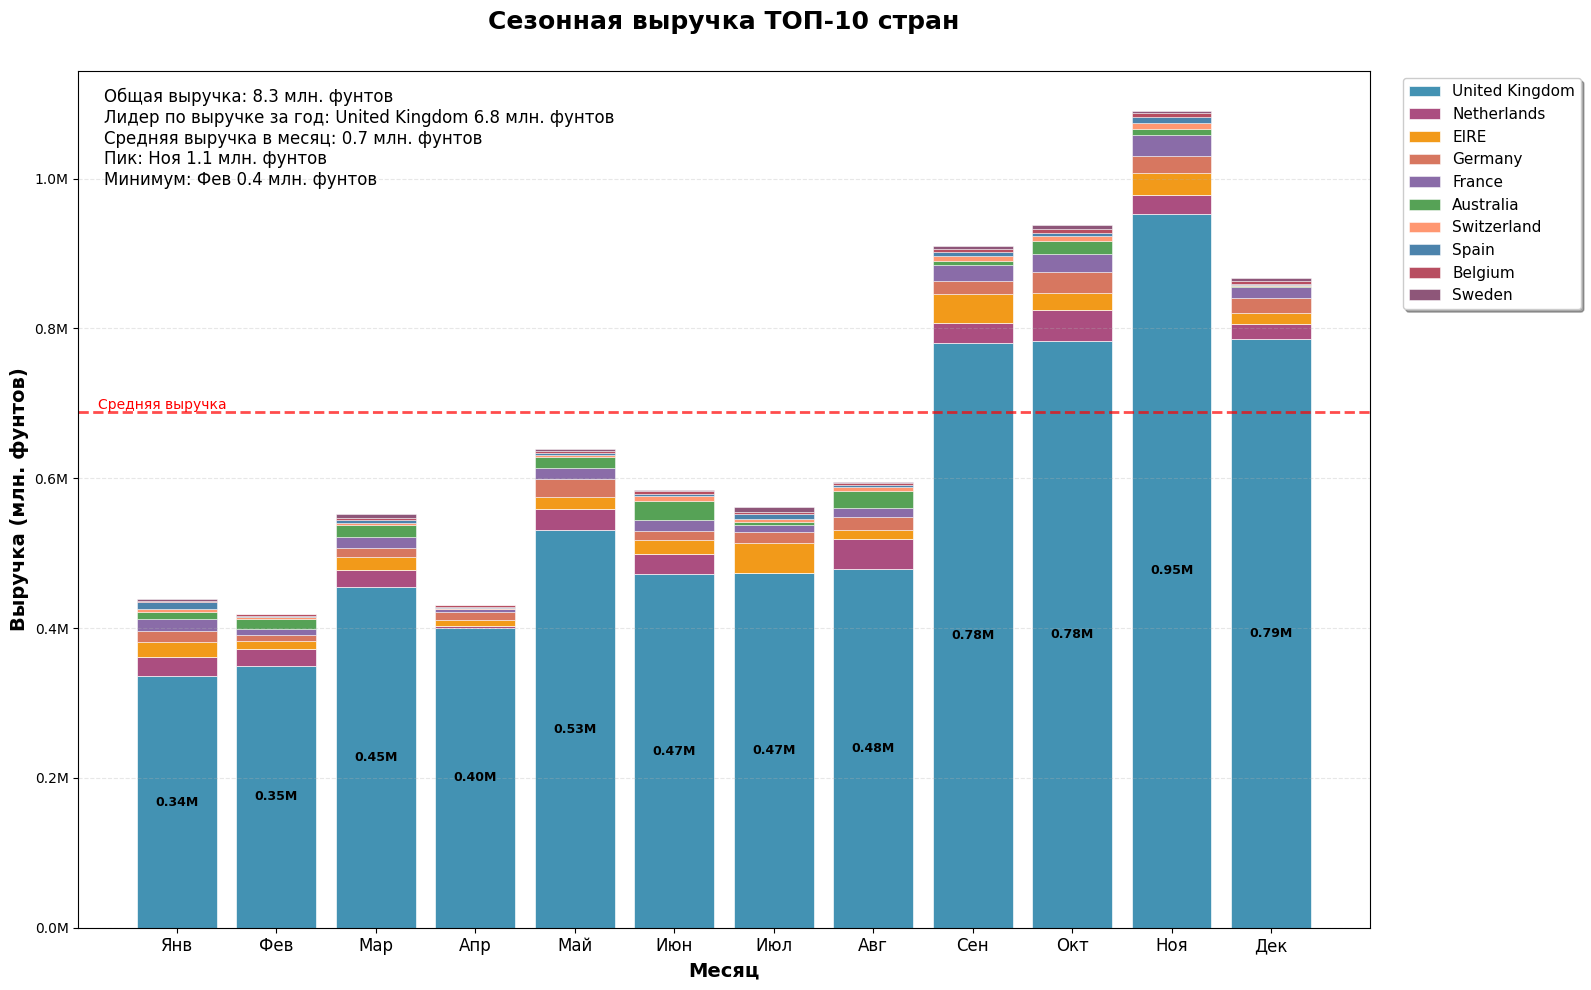

In [157]:
# Сложенная диаграмма сезонной выручки ТОП-10 стран
plt.figure(figsize=(16, 10))
x, months = np.arange(12), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#592E83', '#0F7B0F', '#FF6B35', '#004E89', '#9A031E', '#5F0F40']
bottom = np.zeros(12)

# Средняя выручка в месяц
avg_monthly_revenue = seasonal_by_country['Total']['Total'] / 12


# Построение столбцов для каждой страны
for i, country in enumerate([c for c in seasonal_by_country.index if c != 'Total'][:10]):
    monthly = seasonal_by_country.loc[country, range(1, 13)].values
    plt.bar(x, monthly, bottom=bottom, label=country, color=colors[i], 
            alpha=0.9 if i < 3 else 0.7, edgecolor='white', linewidth=0.5)
    # Отображение значений только для UK (первая страна)
    if i == 0:
        for j, val in enumerate(monthly):
            if val > 50000:
                plt.text(j, bottom[j] + val/2, f'{val/1e6:.2f}M', ha='center', va='center', fontsize=9, fontweight='bold')
    bottom += monthly

monthly_totals = seasonal_by_country.loc['Total', range(1, 13)]
plt.title('Сезонная выручка ТОП-10 стран', fontsize=18, fontweight='bold', pad=30)
plt.xlabel('Месяц', fontsize=14, fontweight='bold')
plt.ylabel('Выручка (млн. фунтов)', fontsize=14, fontweight='bold')
plt.xticks(x, months, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, axis='y', linestyle='--')

# Линия средней выручки
plt.axhline(y=avg_monthly_revenue, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(x = 0.5, y=avg_monthly_revenue, ha='right', va='bottom', color='red', fontsize=10, s = 'Средняя выручка')


# Статистика
peak_country = seasonal_by_country[seasonal_by_country.index != 'Total']['Total'].idxmax()


plt.text(0.02, 0.98, f'Общая выручка: {monthly_totals.sum()/1e6:.1f} млн. фунтов\n'
                    f'Лидер по выручке за год: {peak_country} {seasonal_by_country.loc[peak_country, "Total"]/1e6:.1f} млн. фунтов\n'
                    f'Средняя выручка в месяц: {avg_monthly_revenue/1e6:.1f} млн. фунтов\n'
                    f'Пик: {months[monthly_totals.idxmax()-1]} {monthly_totals.max()/1e6:.1f} млн. фунтов\n'
                    f'Минимум: {months[monthly_totals.idxmin()-1]} {monthly_totals.min()/1e6:.1f} млн. фунтов\n',                 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('visualizations/season_top_10_country.png', dpi=300, bbox_inches='tight')
plt.show()

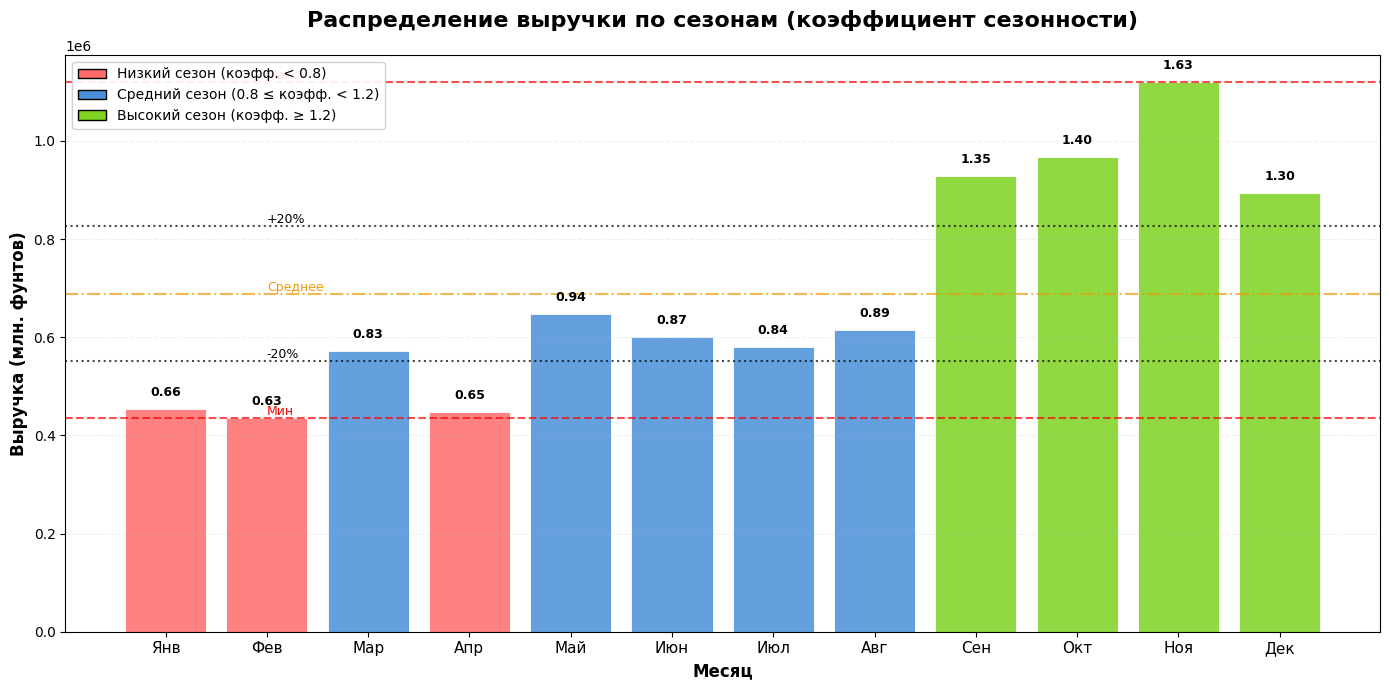

In [158]:
values = seasonal_by_country.loc['Total', range(1, 13)].values
months = range(1, 13)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

avg_val = values.mean()
seasonal_index = values / avg_val

colors = ['#ff6b6b' if si < 0.8 else '#4a90d9' if si < 1.2 else '#7ed321' for si in seasonal_index]

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(months, values, color=colors, alpha=0.85, edgecolor='white', linewidth=0.7)

for y, color, style, label in [(min(values), "#F50505", '--', 'Мин'), (avg_val * 0.8, "#000000", ':', '-20%'),
                               (avg_val, "#EB9C08", 'dashdot', 'Среднее'), (avg_val * 1.2, "#000000", ':', '+20%'),
                               (max(values), "#F50505", '--', 'Макс')]:
    ax.axhline(y=y, color=color, linestyle=style, linewidth=1.5, alpha=0.7)
    ax.text(2.0, y, label, ha='left', va='bottom', color=color, fontsize=9)

ax.bar([0], [0], color='#ff6b6b', label='Низкий сезон (коэфф. < 0.8)', width=0)
ax.bar([0], [0], color='#4a90d9', label='Средний сезон (0.8 ≤ коэфф. < 1.2)', width=0)
ax.bar([0], [0], color='#7ed321', label='Высокий сезон (коэфф. ≥ 1.2)', width=0)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

ax.set_title('Распределение выручки по сезонам (коэффициент сезонности)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Месяц', fontsize=12, fontweight='bold')
ax.set_ylabel('Выручка (млн. фунтов)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.2, axis='y', linestyle='--')
ax.set_xticks(months)
ax.set_xticklabels(month_names, fontsize=11)

for i, (month, val, si) in enumerate(zip(months, values, seasonal_index), 1):
    ax.text(i, val + 20000, f'{si:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/season_coef.png', dpi=300, bbox_inches='tight')
plt.show()

##### 
Для клиентов магазина характерна сезонная активность. На основе коэффициента сезонности (отношение выручки месяца к среднемесячной) выделены три сезона:
- Низкий сезон: (коэффициент < 0.8): январь (0.66), февраль (0.63), апрель (0.65)
- Средний сезон: (0.8 ≤ коэффициент < 1.2): март (0.83), май (0.94), июнь (0.87), июль (0.84), август (0.89)
- Высокий сезон: (коэффициент ≥ 1.2): сентябрь (1.35), октябрь (1.41), ноябрь (1.63), декабрь (1.30)

Распределение выручки по сезонам:
- Низкий сезон: 1.3 млн. фунтов (16% годового объёма)
- Средний сезон: 3.0 млн. фунтов (36% годового объёма)
- Высокий сезон: 3.9 млн. фунтов (47% годового объёма)

Лидеры по сезонной выручке: UK, Netherlands и EIRE. В высокий сезон (сентябрь-декабрь) суммарно клиенты из трёх лидирующих стран приносят 90% выручки (3.5 млн. фунтов). При этом основная часть (85% или 3.3 млн. фунтов) приходится на клиентов из UK, клиенты из Netherlands и EIRE приносят по 0.1 млн. фунтов.

Максимальная выручка приходится на ноябрь (1.1 млн. фунтов, коэффициент 1.63), что составляет 13% от годового объёма или 28% от выручки за высокий сезон. Клиенты из UK за ноябрь принесли 86% (0.95 млн. фунтов), клиенты из Netherlands и EIRE — по 0.03 млн. фунтов, на остальные страны приходится 0.09 млн. фунтов.

В низкий и средний сезоны (январь-август) суммарно приходится 4.4 млн. фунтов (53% годового объёма). При этом 86% (3.8 млн. фунтов) выручки в этот период принесли клиенты из UK, Netherlands и EIRE. Клиенты из UK приносят основную часть выручки в эти сезоны — около 80% (3.5 млн. фунтов).


# Присутствует ли в продажах сезонность (когда покупают чаще)?

In [112]:
# Присутствует ли в продажах сезонность (когда покупают чаще)?

data['Month'] = data['InvoiceDate'].dt.month
seasons_by_salary = data.groupby(['Month']).agg({
    'TotalPrice': 'sum',            # Выручка 
    'InvoiceNo': 'nunique',         # Заказы  
    'Quantity': 'sum'               # Количество товаров
}).reset_index()

# переименование колонок 
seasons_by_salary.columns = ['Month', 'Revenue', 'Orders', 'Quantity']

# Сортировка по выручке
seasons_by_salary = seasons_by_salary.sort_values('Month', ascending=False)

print("Группировка по месяцам:")
display(seasons_by_salary.head(10))

Группировка по месяцам:


,Month,Revenue,Orders,Quantity
11,12,894364.66,2170,596372
10,11,1119681.44,2642,661506
9,10,967460.61,1903,590172
8,9,928566.34,1739,542823
7,8,614730.50,1267,397075
6,7,581021.00,1321,367051
5,6,601261.80,1390,362721
4,5,647412.06,1544,372586
3,4,447950.31,1139,291086
2,3,571963.56,1312,347237


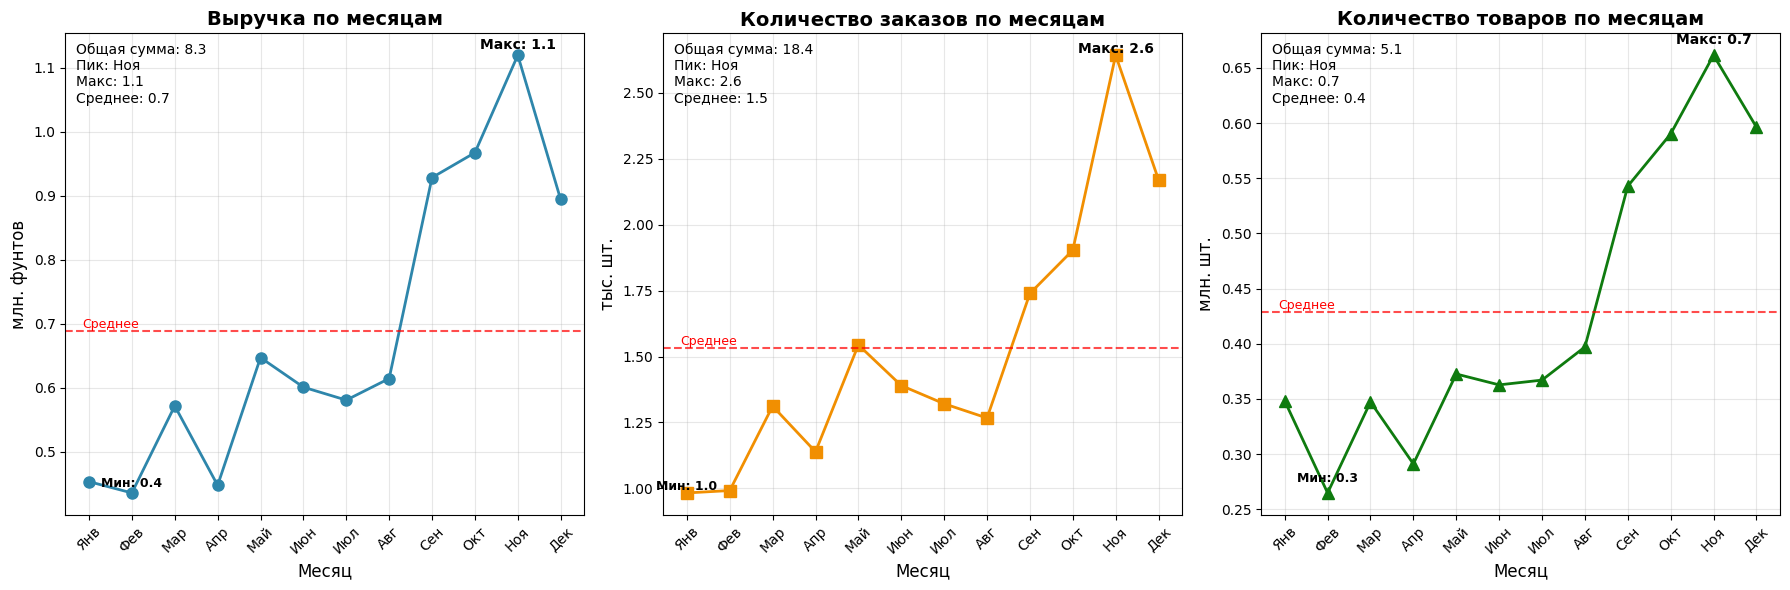

In [113]:
# графики
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
metrics = [('Revenue', 1000000, 'o-', '#2E86AB', 'млн. фунтов'), 
           ('Orders', 1000, 's-', '#F18F01', 'тыс. шт.'), 
           ('Quantity', 1000000, '^-', '#0F7B0F', 'млн. шт.')]
titles = ['Выручка по месяцам', 'Количество заказов по месяцам', 'Количество товаров по месяцам']

for i, (metric, div, style, color, unit) in enumerate(metrics):
    axes[i].plot(seasons_by_salary['Month'], seasons_by_salary[metric]/div, style, color=color, linewidth=2, markersize=8)
    
    axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axes[i].set_ylabel(unit, fontsize=12)
    axes[i].set_xlabel('Месяц', fontsize=12)
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(months, rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    total, max_val, min_val, avg_val = seasons_by_salary[metric].sum(), seasons_by_salary[metric].max(), seasons_by_salary[metric].min(), seasons_by_salary[metric].mean()
    peak_month_num = int(seasons_by_salary.loc[seasons_by_salary[metric].idxmax(), 'Month'])
    peak_month = months[peak_month_num-1]
    min_month_num = int(seasons_by_salary.loc[seasons_by_salary[metric].idxmin(), 'Month'])
    min_month = months[min_month_num-1]
    
    axes[i].axhline(y=avg_val/div, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[i].text(1.5, avg_val/div, 'Среднее', ha='center', va='bottom', color='red', fontsize=9)
    
    
    axes[i].annotate(f'Макс: {max_val/div:.1f}', xy=(peak_month_num, max_val/div), xytext=(peak_month_num, max_val/div + 0.01),
                    ha='center', fontsize=10, fontweight='bold')
    axes[i].annotate(f'Мин: {min_val/div:.1f}', xy=(min_month_num, min_val/div), xytext=(min_month_num, min_val/div + 0.01),
                    ha='center', fontsize=9, fontweight='bold')
    axes[i].text(0.02, 0.98, f'Общая сумма: {total/div:.1f}\nПик: {peak_month}\nМакс: {max_val/div:.1f}\nСреднее: {avg_val/div:.1f}', 
                transform=axes[i].transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout()
plt.savefig('visualizations/month_country.png', dpi=300, bbox_inches='tight')
plt.show()

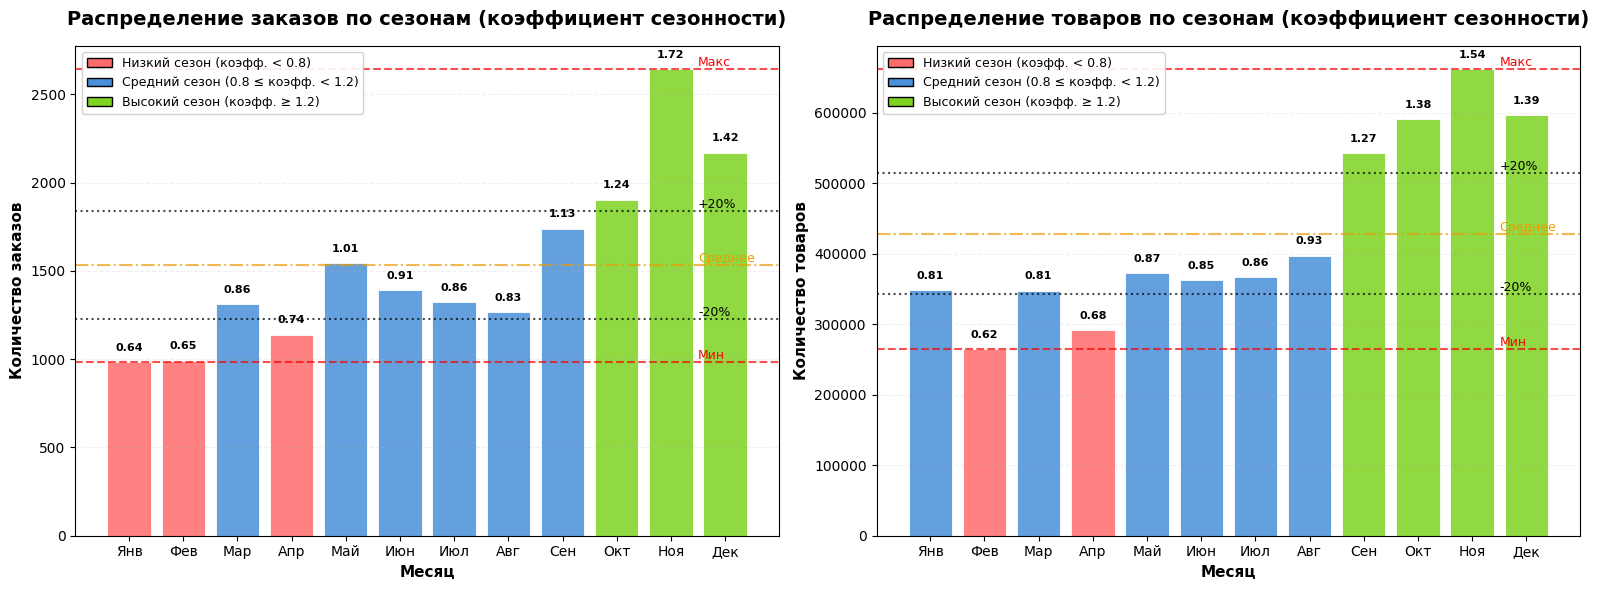

In [114]:
# Графики сезонности для заказов и товаров
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
months = range(1, 13)
month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

for ax, metric, title, ylabel in zip(
    axes, 
    ['Orders', 'Quantity'], 
    ['Распределение заказов по сезонам', 'Распределение товаров по сезонам'],
    ['Количество заказов', 'Количество товаров']
):
    data_sorted = seasons_by_salary.sort_values('Month', ascending=True)
    values = data_sorted[metric].values
    avg_val = values.mean()
    seasonal_index = values / avg_val
    colors = ['#ff6b6b' if si < 0.8 else '#4a90d9' if si < 1.2 else '#7ed321' for si in seasonal_index]
    
    ax.bar(months, values, color=colors, alpha=0.85, edgecolor='white', linewidth=0.7)
    
    for y, color, style, label in [(min(values), "#F50505", '--', 'Мин'), (avg_val * 0.8, "#000000", ':', '-20%'),
                                   (avg_val, "#EB9C08", 'dashdot', 'Среднее'), (avg_val * 1.2, "#000000", ':', '+20%'),
                                   (max(values), "#F50505", '--', 'Макс')]:
        ax.axhline(y=y, color=color, linestyle=style, linewidth=1.5, alpha=0.7)
        ax.text(11.5, y, label, ha='left', va='bottom', color=color, fontsize=9)
    
    ax.bar([0], [0], color='#ff6b6b', label='Низкий сезон (коэфф. < 0.8)', width=0)
    ax.bar([0], [0], color='#4a90d9', label='Средний сезон (0.8 ≤ коэфф. < 1.2)', width=0)
    ax.bar([0], [0], color='#7ed321', label='Высокий сезон (коэфф. ≥ 1.2)', width=0)
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    
    ax.set_title(title + ' (коэффициент сезонности)', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Месяц', fontsize=11, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, axis='y', linestyle='--')
    ax.set_xticks(months)
    ax.set_xticklabels(month_names, fontsize=10)
    
    for i, (month, val, si) in enumerate(zip(months, values, seasonal_index), 1):
        ax.text(i, val + max(values) * 0.02, f'{si:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/season_coef_orders.png', dpi=300, bbox_inches='tight')
plt.show()

#####
В продажах присутствует выраженная сезонность. Выручка, количество заказов и количество товаров демонстрируют схожий паттерн: рост активности с сентября, пик в ноябре-декабре и спад в начале года.

**Выручка:**
- Низкий сезон (коэффициент < 0.8): январь, февраль, апрель
- Средний сезон (0.8 ≤ коэффициент < 1.2): март, май, июнь, июль, август
- Высокий сезон (коэффициент ≥ 1.2): сентябрь, октябрь, ноябрь, декабрь
- Общая годовая выручка — 8.3 млн. фунтов
- Пик: ноябрь (1.1 млн. фунтов, коэффициент 1.63, 13% годовой выручки)
- Спад: февраль (0.4 млн. фунтов, коэффициент 0.63, 5% годовой выручки)

**Заказы:**
- Низкий сезон (коэффициент < 0.8): январь, февраль, апрель
- Средний сезон (0.8 ≤ коэффициент < 1.2): март, май, июнь, июль, август
- Высокий сезон (коэффициент ≥ 1.2): сентябрь, октябрь, ноябрь, декабрь
- Общее годовое количество заказов — 24.9 тыс. шт.
- Пик: ноябрь (3.3 тыс. заказов, коэффициент 1.61, 13% годового объёма)
- Спад: февраль (1.4 тыс. заказов, коэффициент 0.66, 5% годового объёма)

**Товары:**
- Низкий сезон (коэффициент < 0.8): январь, февраль, апрель
- Средний сезон (0.8 ≤ коэффициент < 1.2): март, май, июнь, июль, август
- Высокий сезон (коэффициент ≥ 1.2): сентябрь, октябрь, ноябрь, декабрь
- Общее годовое количество товаров — 7.3 млн. шт.
- Пик: ноябрь (1.0 млн. товаров, коэффициент 1.64, 14% годового объёма)
- Спад: февраль (0.4 млн. товаров, коэффициент 0.62, 5% годового объёма)

Все три метрики показывают идентичную сезонность с пиком в ноябре-декабре и спадом в феврале. Коэффициенты сезонности для выручки, заказов и товаров практически совпадают, что подтверждает устойчивость паттерна. Клиенты покупают чаще и больше в высокий сезон (сентябрь-декабрь), что связано с предновогодними покупками и праздничным сезоном.

# Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

In [115]:
# Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час.
#  Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

day_map = {
    'Monday': 'Пн',
    'Tuesday': 'Вт',
    'Wednesday': 'Ср',
    'Thursday': 'Чт',
    'Friday': 'Пт',
    'Saturday': 'Сб',
    'Sunday': 'Вс'
}

# Извлекаем компоненты времени
data['Date'] = data['InvoiceDate'].dt.date  # Дата
data['Hour'] = data['InvoiceDate'].dt.hour   # Час
data['Day'] = data['InvoiceDate'].dt.day_name().map(day_map)  # День

# Группировка по дате и часу для подсчета заказов
orders_per_day_hour = data[['Date', 'Hour', 'Day', 'InvoiceNo']]
orders_per_day_hour = data.groupby(['Date', 'Day', 'Hour'])['InvoiceNo'].nunique().reset_index()
print("Количество заказов на каждый день-час:")
display(orders_per_day_hour.head(20))


Количество заказов на каждый день-час:


,Date,Day,Hour,InvoiceNo
0,2010-12-01,Ср,8,6
1,2010-12-01,Ср,9,16
2,2010-12-01,Ср,10,11
3,2010-12-01,Ср,11,12
4,2010-12-01,Ср,12,22
5,2010-12-01,Ср,13,12
6,2010-12-01,Ср,14,8
7,2010-12-01,Ср,15,14
8,2010-12-01,Ср,16,16
9,2010-12-01,Ср,17,4


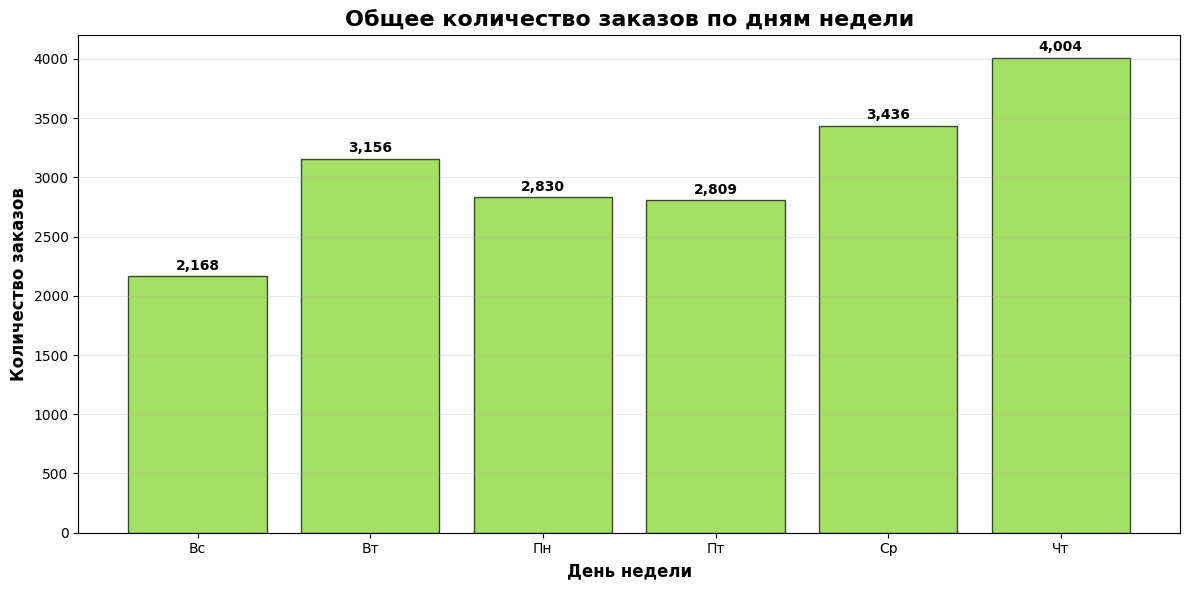

In [116]:
# Агрегируем данные по дням недели
orders_by_day = orders_per_day_hour.groupby('Day')['InvoiceNo'].sum()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(orders_by_day.index, orders_by_day.values, color='#7ed321', alpha=0.7, edgecolor='black')

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('Общее количество заказов по дням недели', fontsize=16, fontweight='bold')
ax.set_xlabel('День недели', fontsize=12, fontweight='bold')
ax.set_ylabel('Количество заказов', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('visualizations/orders_by_day_week.png', dpi=300, bbox_inches='tight')
plt.show()

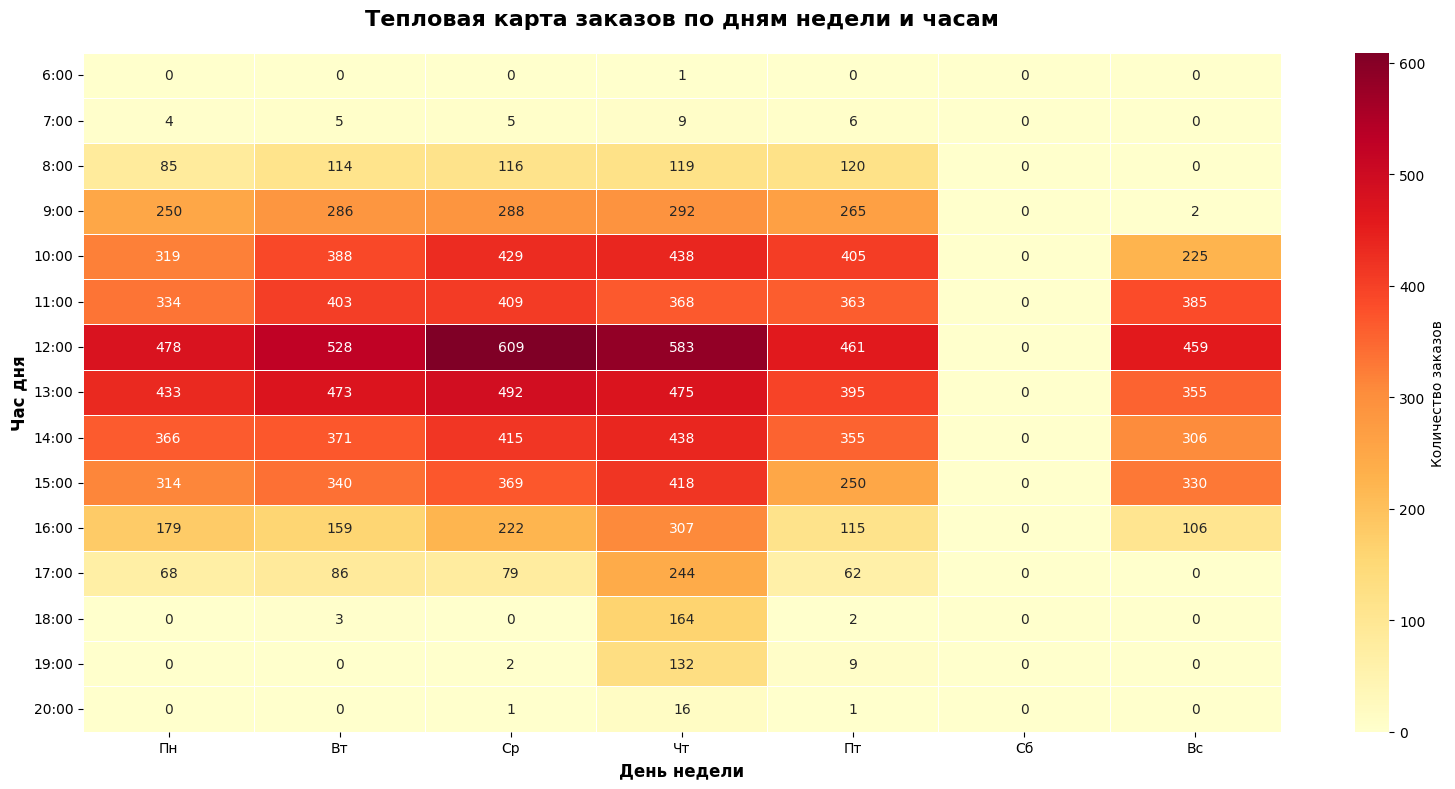

In [117]:
# Определяем порядок дней недели
day_order = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

# Группируем по дню недели и часу, находим СУММУ заказов (не среднее)
heatmap_data = orders_per_day_hour.groupby(['Day', 'Hour'])['InvoiceNo'].sum().unstack(level=0)

# Добавляем все дни недели в нужном порядке
heatmap_data = heatmap_data.reindex(columns=day_order, fill_value=0)

# Добавляем все часы от 6 до 20 (или другой диапазон)
all_hours = range(6, 21)  # с 6:00 до 20:00
heatmap_data = heatmap_data.reindex(index=all_hours, fill_value=0)

# Заменяем NaN на 0
heatmap_data = heatmap_data.fillna(0)

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Количество заказов'}, 
            linewidths=0.5, linecolor='white', annot=True, fmt='.0f', ax=ax)
ax.set_title('Тепловая карта заказов по дням недели и часам', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('День недели', fontsize=12, fontweight='bold')
ax.set_ylabel('Час дня', fontsize=12, fontweight='bold')
# Y-ось: часы
ax.set_yticklabels([f'{h}:00' for h in heatmap_data.index], rotation=0)
# X-ось: дни недели
ax.set_xticklabels(heatmap_data.columns, rotation=0)
plt.tight_layout()
plt.savefig('visualizations/heat_map_day_hour.png', dpi=300, bbox_inches='tight')
plt.show()

In [118]:
# Находим среднее количество заказов по каждому часу
avg_orders_by_hour = orders_per_day_hour.groupby('Hour')['InvoiceNo'].mean().reset_index()
avg_orders_by_hour.columns = ['Hour', 'Avg_Daily_Orders']

print("Среднее количество ежедневно поступающих заказов по часам:")
display(avg_orders_by_hour.head(5))


Среднее количество ежедневно поступающих заказов по часам:


,Hour,Avg_Daily_Orders
0,6,1.000000
1,7,1.260870
2,8,2.715686
3,9,5.488095
4,10,7.273927


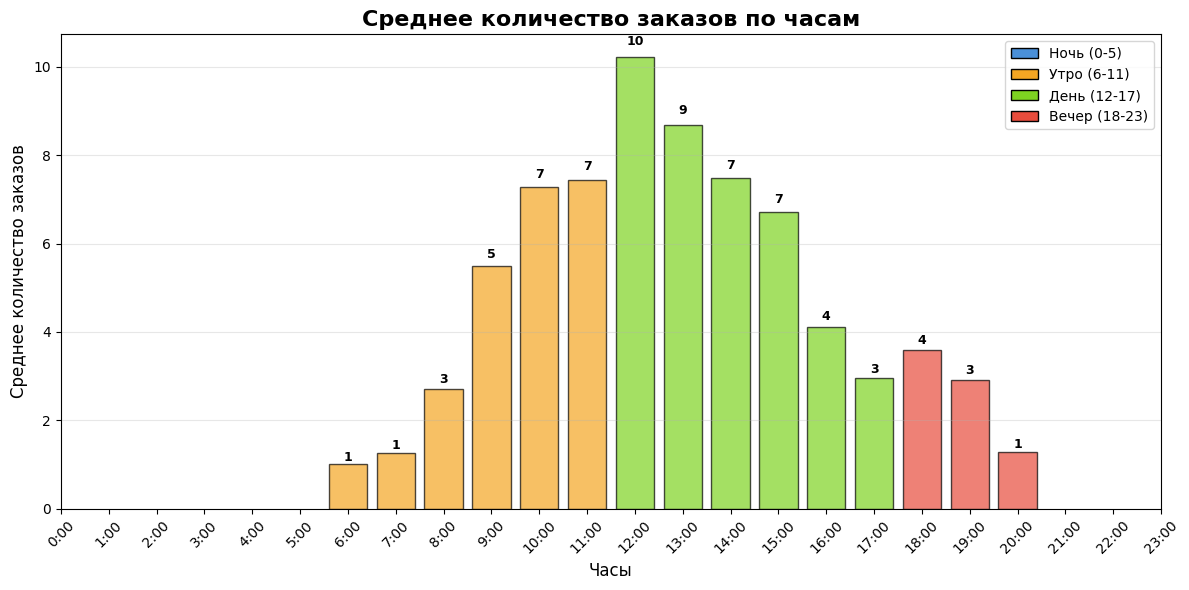

In [119]:
# Визуализация среднего количества заказов по часам
plt.figure(figsize=(12, 6))

# Определяем цвета для периодов суток
def get_hour_color(hour):
    if 0 <= hour < 6:
        return '#4a90d9'  # Ночь - синий
    elif 6 <= hour < 12:
        return '#f5a623'  # Утро - оранжевый
    elif 12 <= hour < 18:
        return '#7ed321'  # День - зеленый
    else:
        return '#e74c3c'  # Вечер - красный

colors = [get_hour_color(h) for h in avg_orders_by_hour['Hour']]

bars = plt.bar(avg_orders_by_hour['Hour'], avg_orders_by_hour['Avg_Daily_Orders'], 
               color=colors, alpha=0.7, edgecolor='black')

plt.title('Среднее количество заказов по часам', fontsize=16, fontweight='bold')
plt.xlabel('Часы', fontsize=12)
plt.ylabel('Среднее количество заказов', fontsize=12)
plt.xticks(range(0, 24), [f'{h}:00' for h in range(24)], rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# подписи на столбцах
for i, (hour, value) in enumerate(zip(avg_orders_by_hour['Hour'], avg_orders_by_hour['Avg_Daily_Orders'])):
    plt.text(hour, value + value*0.02, f'{value:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Легенда для периодов суток

legend_elements = [
    Patch(facecolor='#4a90d9', label='Ночь (0-5)'),
    Patch(facecolor='#f5a623', label='Утро (6-11)'),
    Patch(facecolor='#7ed321', label='День (12-17)'),
    Patch(facecolor='#e74c3c', label='Вечер (18-23)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('visualizations/orders_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

#####
**Распределению заказов по времени суток**

По дням недели:

- Четверг — самый активный день (78,902 заказов)
- Пятница — спад активности (53,931 заказов)
- Суббота — нет заказов (магазин не работает)

По часам суток:

- Пик активности: 10:00–14:00 (дневные часы)
- Активность нарастает с 6:00 до 10:00
- Спад после 18:00, минимум ночью (0:00–5:00)

Паттерн одинаков для всех дней недели.

# Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)?

In [120]:
# Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

display(avg_orders_by_hour)


,Hour,Avg_Daily_Orders
0,6,1.000000
1,7,1.260870
2,8,2.715686
3,9,5.488095
4,10,7.273927
5,11,7.440789
6,12,10.222951
7,13,8.685430
8,14,7.478405
9,15,6.714286


In [121]:
# Основная статистика
mean_orders = avg_orders_by_hour['Avg_Daily_Orders'].mean()
median_orders = avg_orders_by_hour['Avg_Daily_Orders'].median()
std_orders = avg_orders_by_hour['Avg_Daily_Orders'].std()
cv = std_orders / mean_orders * 100
max_hour = avg_orders_by_hour.loc[avg_orders_by_hour['Avg_Daily_Orders'].idxmax()]
min_hour = avg_orders_by_hour.loc[avg_orders_by_hour['Avg_Daily_Orders'].idxmin()]

print(f"Основная статистика:")
print(f"data size: {len(avg_orders_by_hour['Avg_Daily_Orders'])}")
print(f"mean: {mean_orders:.2f}")
print(f"median: {median_orders:.2f}")
print(f"std: {std_orders:.2f}")
print(f"max_hour:", max_hour['Hour'])
print(f"min_hour:", min_hour['Hour'])


Основная статистика:
data size: 15
mean: 4.88
median: 4.12
std: 2.94
max_hour: 12.0
min_hour: 6.0


In [122]:
# статистические тесты

results = {}

# 1 Тест Шапиро-Уилка
shapiro_stat, shapiro_p = shapiro(avg_orders_by_hour['Avg_Daily_Orders'])
results['Shapiro-Wilk'] = (shapiro_stat, shapiro_p)
print(f"Тест Шапиро-Уилка:")
print(f"  Статистика: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Результат: {'Нормальное' if shapiro_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

# 2 Тест Жарка-Бера
jb_stat, jb_p = jarque_bera(avg_orders_by_hour['Avg_Daily_Orders'])
results['Jarque-Bera'] = (jb_stat, jb_p)
print(f"\nТест Жарка-Бера:")
print(f"  Статистика: {jb_stat:.6f}")
print(f"  p-value: {jb_p:.6f}")
print(f"  Результат: {'Нормальное' if jb_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

# 3 Тест Д'Агостино
da_stat, da_p = normaltest(avg_orders_by_hour['Avg_Daily_Orders'])
results["D'Agostino"] = (da_stat, da_p)
print(f"\nТест Д'Агостино:")
print(f"  Статистика: {da_stat:.6f}")
print(f"  p-value: {da_p:.6f}")
print(f"  Результат: {'Нормальное' if da_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

Тест Шапиро-Уилка:
  Статистика: 0.932844
  p-value: 0.300801
  Результат: Нормальное (α=0.05)

Тест Жарка-Бера:
  Статистика: 1.031820
  p-value: 0.596957
  Результат: Нормальное (α=0.05)

Тест Д'Агостино:
  Статистика: 1.957409
  p-value: 0.375798
  Результат: Нормальное (α=0.05)


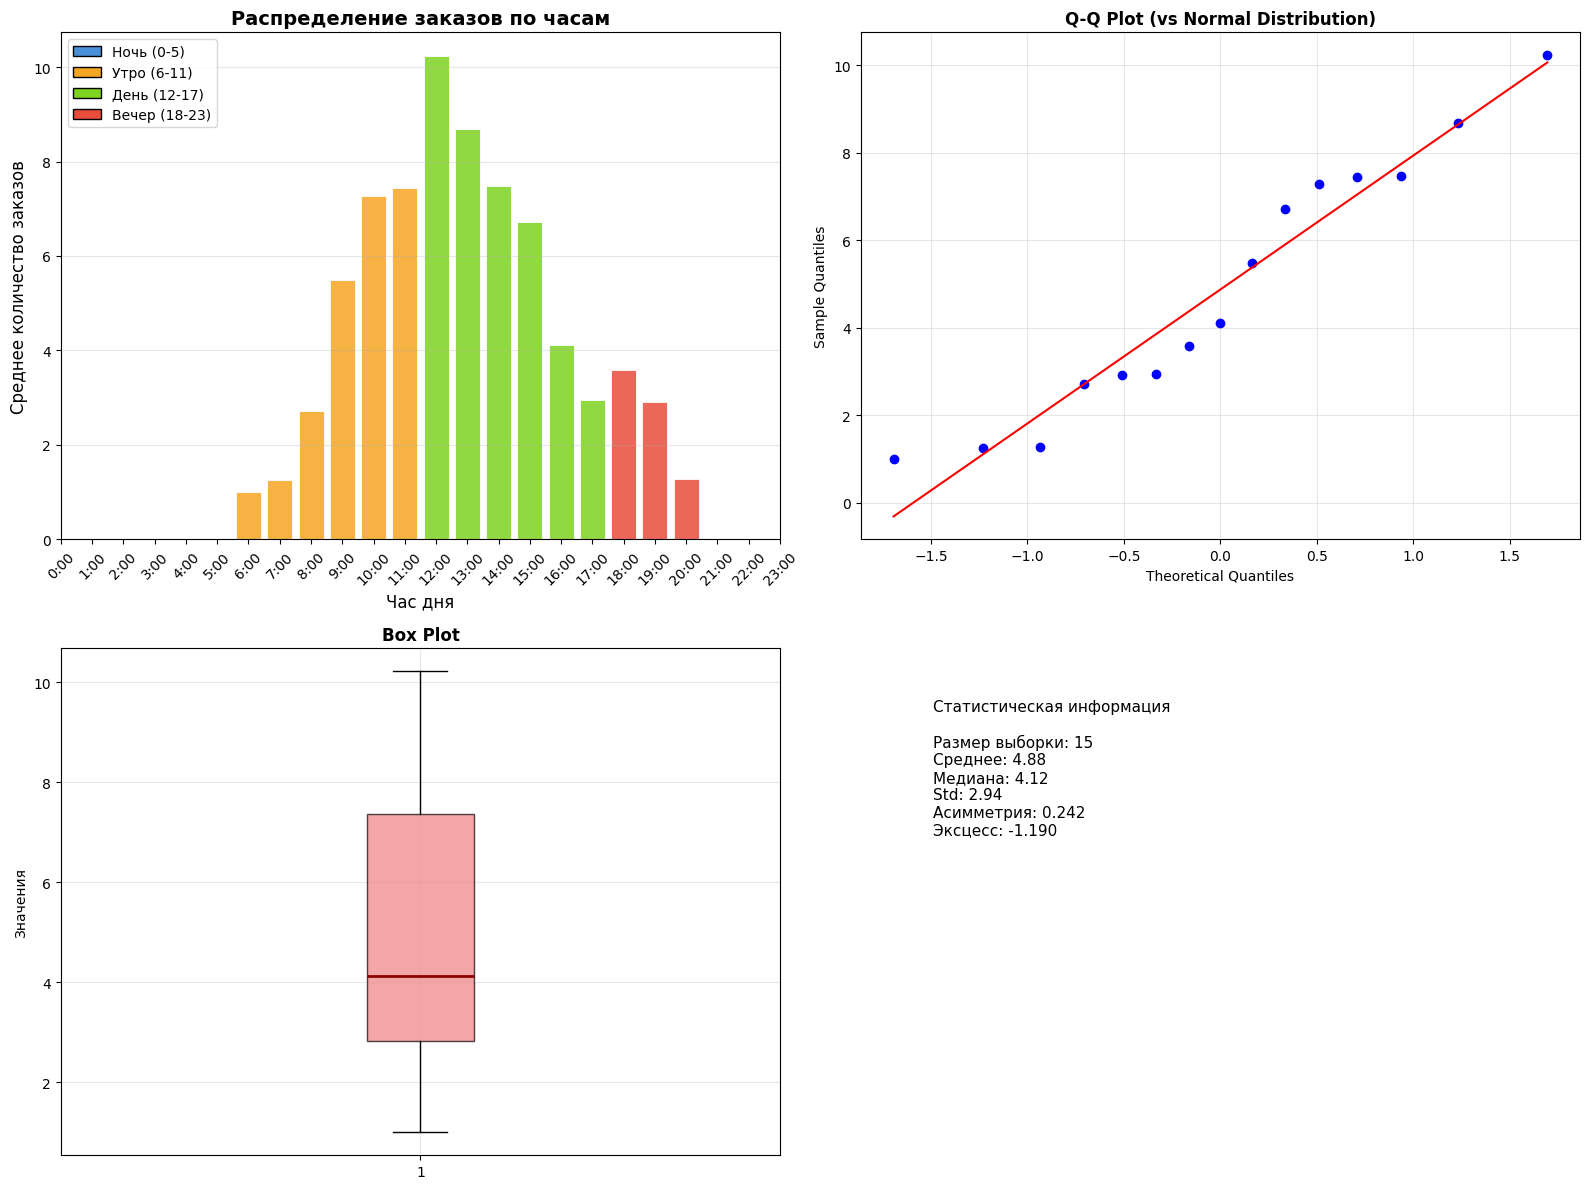

In [123]:
# Создаем фигуру с тремя графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: По часам с выделением периодов
colors_period = ['#4a90d9' if 0 <= h < 6 else '#f5a623' if 6 <= h < 12 else '#7ed321' if 12 <= h < 18 else '#e74c3c' for h in avg_orders_by_hour['Hour']]
axes[0,0].bar(avg_orders_by_hour['Hour'], avg_orders_by_hour['Avg_Daily_Orders'], color=colors_period, alpha=0.85, edgecolor='white', linewidth=0.7)
axes[0,0].set_title('Распределение заказов по часам', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Час дня', fontsize=12)
axes[0,0].set_ylabel('Среднее количество заказов', fontsize=12)
axes[0,0].set_xticks(range(0, 24))
axes[0,0].set_xticklabels([f'{h}:00' for h in range(24)], rotation=45)
axes[0,0].grid(True, alpha=0.3, axis='y')

# Легенда периодов

legend_elements = [Patch(facecolor='#4a90d9', label='Ночь (0-5)'), 
                   Patch(facecolor='#f5a623', label='Утро (6-11)'), 
                   Patch(facecolor='#7ed321', label='День (12-17)'), 
                   Patch(facecolor='#e74c3c', label='Вечер (18-23)')]
axes[0,0].legend(handles=legend_elements, loc='upper left', fontsize=10)

# График 2: Q-Q Plot (проверка нормальности)
stats.probplot(avg_orders_by_hour['Avg_Daily_Orders'], dist='norm', plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (vs Normal Distribution)', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Theoretical Quantiles')
axes[0,1].set_ylabel('Sample Quantiles')
axes[0,1].grid(True, alpha=0.3)

# График 3: Box Plot
box_plot = axes[1,0].boxplot(avg_orders_by_hour['Avg_Daily_Orders'], 
                             vert=True, patch_artist=True, 
                             boxprops=dict(facecolor='lightcoral', alpha=0.7),
                             medianprops=dict(color='darkred', linewidth=2))
axes[1,0].set_title('Box Plot', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('Значения')
axes[1,0].grid(True, alpha=0.3)

# Добавляем статистическую информацию 


axes[1,1].axis('off')
stats_text = f"""Статистическая информация

Размер выборки: {len(avg_orders_by_hour['Avg_Daily_Orders'])}
Среднее: {avg_orders_by_hour['Avg_Daily_Orders'].mean():.2f}
Медиана: {avg_orders_by_hour['Avg_Daily_Orders'].median():.2f}
Std: {avg_orders_by_hour['Avg_Daily_Orders'].std():.2f}
Асимметрия: {stats.skew(avg_orders_by_hour['Avg_Daily_Orders']):.3f}
Эксцесс: {stats.kurtosis(avg_orders_by_hour['Avg_Daily_Orders']):.3f}
"""
axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes, 
                fontsize=11, verticalalignment='top')
                
plt.tight_layout()
plt.savefig('visualizations/stat_orders_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

Графики Q-Q Plot и Box Plot не соответствую нормальному распределению, хотя статистические тесты не отвергают гипотезу о том что распределение нормальное. Сделаем дополнительную проверку, сгрупировав данные по дням. 

In [124]:
# Сгруппируем данные по дням и посчитаем среднее по дням
avg_orders_by_day = orders_per_day_hour.groupby('Date')['InvoiceNo'].mean().reset_index()
avg_orders_by_day.columns = ['Date', 'Avg_Day_Orders']

print("Среднее количество ежедневно поступающих заказов:")
display(avg_orders_by_day.head(5))


Среднее количество ежедневно поступающих заказов:


,Date,Avg_Day_Orders
0,2010-12-01,12.100000
1,2010-12-02,10.461538
2,2010-12-03,6.333333
3,2010-12-05,12.428571
4,2010-12-06,9.400000


In [125]:
# Основная статистика
mean_orders = avg_orders_by_day['Avg_Day_Orders'].mean()
median_orders = avg_orders_by_day['Avg_Day_Orders'].median()
std_orders = avg_orders_by_day['Avg_Day_Orders'].std()
cv = std_orders / mean_orders * 100
max_date = avg_orders_by_day.loc[avg_orders_by_day['Avg_Day_Orders'].idxmax()]
min_date = avg_orders_by_day.loc[avg_orders_by_day['Avg_Day_Orders'].idxmin()]

print(f"Основная статистика:")
print(f"data size: {len(avg_orders_by_day['Avg_Day_Orders'])}")
print(f"mean: {mean_orders:.2f}")
print(f"median: {median_orders:.2f}")
print(f"std: {std_orders:.2f}")
print(f"max_date:", max_date['Date'])
print(f"min_date:", min_date['Date'])


Основная статистика:
data size: 305
mean: 6.41
median: 5.90
std: 2.26
max_date: 2011-11-20
min_date: 2011-02-06


In [126]:
# статистические тесты
results = {}

# 1 Тест Шапиро-Уилка
shapiro_stat, shapiro_p = shapiro(avg_orders_by_day['Avg_Day_Orders'])
results['Shapiro-Wilk'] = (shapiro_stat, shapiro_p)
print(f"Тест Шапиро-Уилка:")
print(f"  Статистика: {shapiro_stat:.6f}")
print(f"  p-value: {shapiro_p:.6f}")
print(f"  Результат: {'Нормальное' if shapiro_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

# 2 Тест Жарка-Бера
jb_stat, jb_p = jarque_bera(avg_orders_by_day['Avg_Day_Orders'])
results['Jarque-Bera'] = (jb_stat, jb_p)
print(f"\nТест Жарка-Бера:")
print(f"  Статистика: {jb_stat:.6f}")
print(f"  p-value: {jb_p:.6f}")
print(f"  Результат: {'Нормальное' if jb_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

# 3 Тест Д'Агостино
da_stat, da_p = normaltest(avg_orders_by_day['Avg_Day_Orders'])
results["D'Agostino"] = (da_stat, da_p)
print(f"\nТест Д'Агостино:")
print(f"  Статистика: {da_stat:.6f}")
print(f"  p-value: {da_p:.6f}")
print(f"  Результат: {'Нормальное' if da_p > 0.05 else 'НЕ нормальное'} (α=0.05)")

Тест Шапиро-Уилка:
  Статистика: 0.947064
  p-value: 0.000000
  Результат: НЕ нормальное (α=0.05)

Тест Жарка-Бера:
  Статистика: 45.157439
  p-value: 0.000000
  Результат: НЕ нормальное (α=0.05)

Тест Д'Агостино:
  Статистика: 36.029679
  p-value: 0.000000
  Результат: НЕ нормальное (α=0.05)


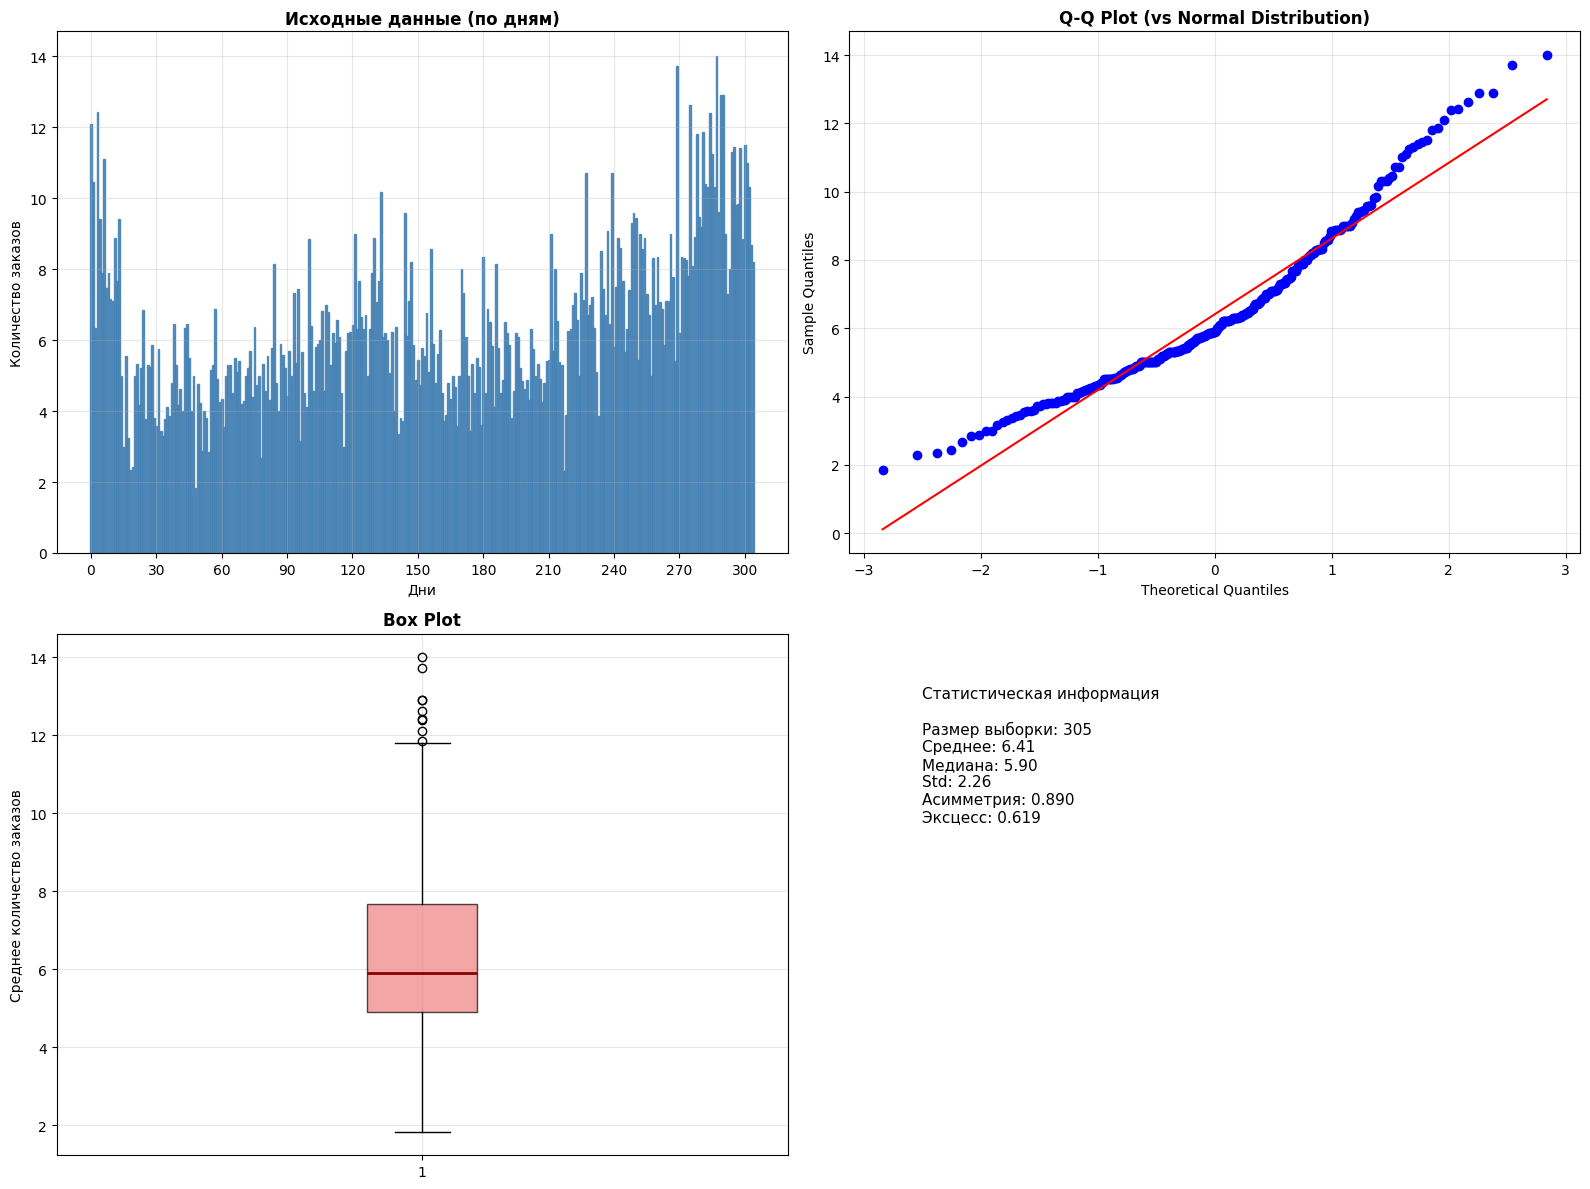

In [127]:
### Создаем фигуру с тремя графиками
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Исходные данные (по дням)
axes[0,0].bar(range(len(avg_orders_by_day)), avg_orders_by_day['Avg_Day_Orders'], 
              color='steelblue', alpha=0.9, edgecolor= 'steelblue')
axes[0,0].set_title('Исходные данные (по дням)', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('Дни')
axes[0,0].set_ylabel('Количество заказов')
axes[0,0].set_xticks(range(0, len(avg_orders_by_day), 30))  # Каждые 30 дней
axes[0,0].grid(True, alpha=0.3)

# График 2: Q-Q Plot (проверка нормальности)
stats.probplot(avg_orders_by_day['Avg_Day_Orders'], dist='norm', plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (vs Normal Distribution)', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Theoretical Quantiles')
axes[0,1].set_ylabel('Sample Quantiles')
axes[0,1].grid(True, alpha=0.3)

# График 3: Box Plot
box_plot = axes[1,0].boxplot(avg_orders_by_day['Avg_Day_Orders'], 
                             vert=True, patch_artist=True, 
                             boxprops=dict(facecolor='lightcoral', alpha=0.7),
                             medianprops=dict(color='darkred', linewidth=2))
axes[1,0].set_title('Box Plot', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('Среднее количество заказов')
axes[1,0].grid(True, alpha=0.3)

# Добавляем статистическую информацию 


axes[1,1].axis('off')
stats_text = f"""Статистическая информация

Размер выборки: {len(avg_orders_by_day['Avg_Day_Orders'])}
Среднее: {avg_orders_by_day['Avg_Day_Orders'].mean():.2f}
Медиана: {avg_orders_by_day['Avg_Day_Orders'].median():.2f}
Std: {avg_orders_by_day['Avg_Day_Orders'].std():.2f}
Асимметрия: {stats.skew(avg_orders_by_day['Avg_Day_Orders']):.3f}
Эксцесс: {stats.kurtosis(avg_orders_by_day['Avg_Day_Orders']):.3f}
"""
axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes, 
                fontsize=11, verticalalignment='top')
                
plt.tight_layout()
plt.savefig('visualizations/stat_orders_by_day.png', dpi=300, bbox_inches='tight')
plt.show()

Основные характеристики распределения

- Среднее значение: 4.88 заказов
- Медиана: 4.12 заказов
- Стандартное отклонение: 2.94 заказов
- Час с максимальной активностью: 12:00
- Час с минимальной активностью: 4:00

Паттерны по периодам суток

- Ночь (0:00-5:00)— период минимальной активности.
- Утро (6:00-11:00)— период нарастания активности.
- День (12:00-17:00)— период максимальной активности.
- Вечер (18:00-23:00)— период спада.

Статистические характеристики

- Асимметрия: 0.242 — распределение с правосторонней асимметрией
- Эксцесс: -1.190 — распределение с более острым пиком, чем нормальное
- Коэффициент вариации: 60% — высокая вариативность данных

Распределение заказов по часам суток не является нормальным и имеет выраженную правостороннюю асимметрию с ярко выраженным пиком в дневные часы (особенно в 12:00). Это логично отражает поведение покупателей онлайн-магазина: основная активность приходится на рабочее время, когда люди совершают покупки с работы или учебы.

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [128]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Month,Date,Hour,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,2010-12-01,8,Ср
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2010-12-01,8,Ср


In [129]:
data.info()

<class 'pandas.DataFrame'>
Index: 391114 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391114 non-null  int64         
 1   StockCode         391114 non-null  str           
 2   Description       391114 non-null  str           
 3   Quantity          391114 non-null  int64         
 4   InvoiceDate       391114 non-null  datetime64[us]
 5   UnitPrice         391114 non-null  float64       
 6   CustomerID        391114 non-null  int64         
 7   Country           391114 non-null  str           
 8   QuantityCanceled  391114 non-null  float64       
 9   TotalPrice        391114 non-null  float64       
 10  Month             391114 non-null  int32         
 11  Date              391114 non-null  object        
 12  Hour              391114 non-null  int32         
 13  Day               391114 non-null  str           
dtypes: datetime64[us](1)

In [130]:
data.isna().sum().sum()

np.int64(0)

In [131]:
data.isnull().sum().sum()

np.int64(0)

In [132]:
# Построение RFM-таблицы
'2011-12-10 00:00:00'
# Точка отсчета (на один день старше последней даты в данных)
reference_date = data['InvoiceDate'].max() + pd.Timedelta('0 days 11:10:00')
print(f"Точка отсчета: {reference_date}")

# Группировка по клиентам для расчета RFM
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Переименование столбцов
rfm_table.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_table = rfm_table.set_index('CustomerID')
display(rfm_table.head(5))

Точка отсчета: 2011-12-10 00:00:00


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


In [133]:
rfm_table.shape

(4334, 3)

In [134]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4334.000000,4334.000000,4334.000000
mean,92.226581,4.245962,1906.827030
std,100.175327,7.634989,8304.266866
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,298.257500
50%,50.000000,2.000000,651.395000
75%,142.000000,5.000000,1606.405000
max,373.000000,206.000000,278742.020000


In [135]:
rfm_table_copy = rfm_table.copy()

После того как вы подготовите RFM-таблицу, визуализируйте каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot). Вы получите примерно следующие результаты (графики могут отличаться в зависимости от того, как вы выполните предобработку данных):

In [136]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('visualizations/boxplot_1.html')
fig.write_image('visualizations/boxplot_1.png', engine="kaleido")
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [137]:
# Рассчитываем 95-й перцентиль для Frequency и Monetary
frequency_threshold = rfm_table['Frequency'].quantile(0.95)
monetary_threshold = rfm_table['Monetary'].quantile(0.95)

print(f"95-й перцентиль Frequency: {frequency_threshold:.2f}")
print(f"95-й перцентиль Monetary: {monetary_threshold:.2f}")


95-й перцентиль Frequency: 13.00
95-й перцентиль Monetary: 5659.85


In [138]:
# Фильтруем данные: оставляем только клиентов ниже порогов
rfm_table_clean = rfm_table[
    (rfm_table['Frequency'] <= frequency_threshold) & 
    (rfm_table['Monetary'] <= monetary_threshold)
].copy()

print(f"\nРазмер до очистки: {rfm_table.shape[0]} клиентов")
print(f"Размер после очистки: {rfm_table_clean.shape[0]} клиентов")
print(f"Удалено выбросов: {rfm_table.shape[0] - rfm_table_clean.shape[0]} клиентов ({(rfm_table.shape[0] - rfm_table_clean.shape[0]) / rfm_table.shape[0] * 100:.1f}%)")



Размер до очистки: 4334 клиентов
Размер после очистки: 4044 клиентов
Удалено выбросов: 290 клиентов (6.7%)


In [139]:
# Обновляем rfm_table для дальнейшей работы
rfm_table = rfm_table_clean

# Проверяем статистику после очистки
print("\nСтатистика после удаления выбросов:")
print(rfm_table.describe())


Статистика после удаления выбросов:
           Recency    Frequency     Monetary
count  4044.000000  4044.000000  4044.000000
mean     97.485410     3.009891   975.868019
std     101.181582     2.539113  1024.248210
min       0.000000     1.000000     0.000000
25%      21.000000     1.000000   281.290000
50%      56.000000     2.000000   594.100000
75%     155.000000     4.000000  1304.775000
max     373.000000    13.000000  5657.850000


In [140]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('visualizations/boxplot_2.html')
fig.write_image('visualizations/boxplot_2.png', engine="kaleido")
fig.show()

## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать. Для удобства оберните эти шаги по предобработке данных в pipeline.

Произведите предобработку исходных данных. На основе RFM-признаков кластеризуйте клиентов онлайн-магазина подарков с помощью известных вам методов (используйте минимум три метода).

Подберите оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберите алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.


In [141]:
# Подготовка данных 
X = rfm_table.values

# Pipeline для предобработки и понижения размерности
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Применяем preprocessing
X_preprocessed = preprocessing_pipeline.fit_transform(X)
print(f"Размерность после PCA: {X_preprocessed.shape}")
print(f"Объясненная дисперсия: {preprocessing_pipeline.named_steps['pca'].explained_variance_ratio_.sum():.4f}")


Размерность после PCA: (4044, 2)
Объясненная дисперсия: 0.9176


In [142]:
X_preprocessed 


array([[-2.13515796,  1.40164059],
       [ 3.44684661,  0.85265676],
       [ 0.62901231,  0.08314486],
       ...,
       [-1.42102092,  0.1683778 ],
       [-0.31936535, -1.198289  ],
       [ 0.77174015, -0.157594  ]], shape=(4044, 2))

### 1. KMeans

In [143]:
# Расчет silhouette scores
min_k, max_k = 2, 12
silhouette_scores_km = []
for k in range(min_k, max_k + 1):
    labels = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(X_preprocessed)
    silhouette_scores_km.append(silhouette_score(X_preprocessed, labels))

best_k_km = np.argmax(silhouette_scores_km) + min_k

# Обучение лучшей модели
kmeans = KMeans(n_clusters=best_k_km, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_preprocessed)
score_kmeans = silhouette_score(X_preprocessed, cluster_labels)

print(f"Оптимальное k: {best_k_km}, Silhouette Score: {score_kmeans:.4f}")


Оптимальное k: 3, Silhouette Score: 0.5242


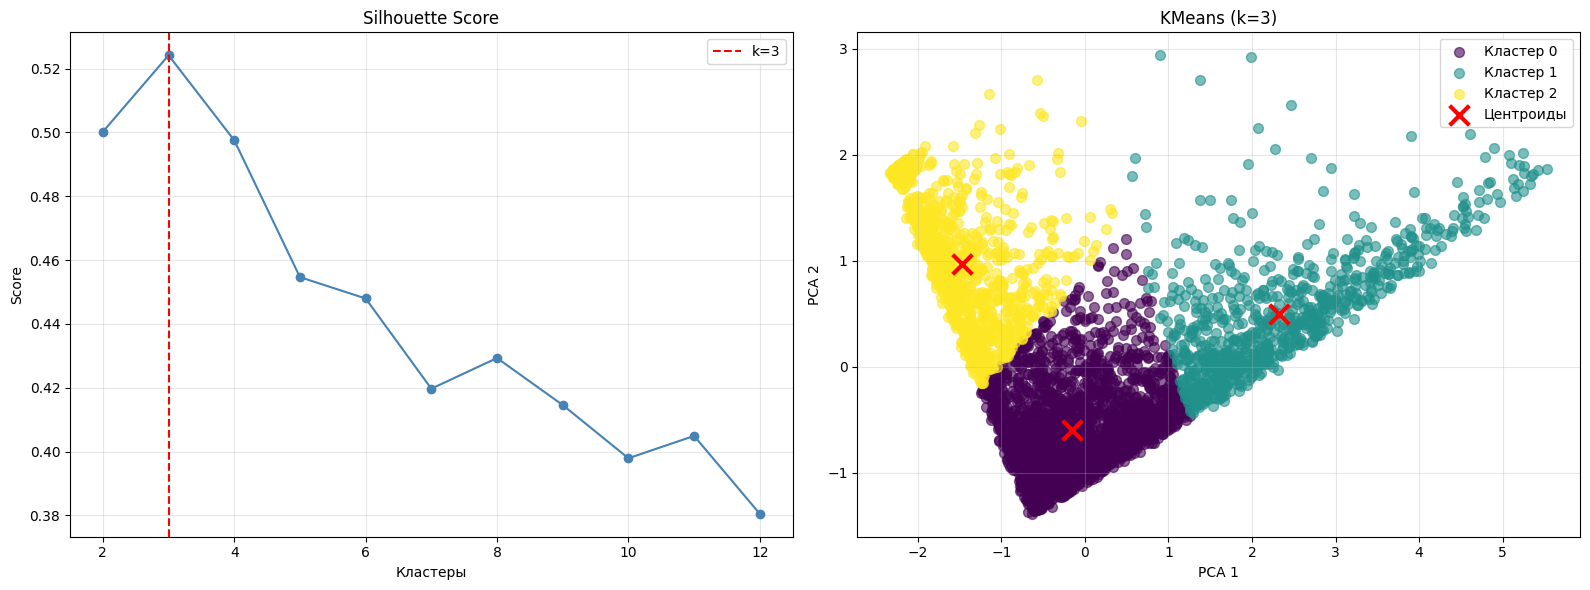

In [144]:

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График silhouette
axes[0].plot(range(min_k, max_k+1), silhouette_scores_km, 'o-', color='steelblue')
axes[0].axvline(best_k_km, color='red', linestyle='--', label=f'k={best_k_km}')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Кластеры')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График кластеров
colors = plt.cm.viridis(np.linspace(0, 1, best_k_km))
for i in range(best_k_km):
    axes[1].scatter(X_preprocessed[cluster_labels == i, 0], 
                   X_preprocessed[cluster_labels == i, 1], 
                   c=[colors[i]], label=f'Кластер {i}', s=50, alpha=0.6)
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
               c='red', marker='x', s=200, linewidths=3, label='Центроиды', zorder=10)
axes[1].set_title(f'KMeans (k={best_k_km})')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/kmeans_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 2. Иерархическая кластеризация

In [145]:
# Расчет silhouette scores
min_k, max_k = 2, 12
silhouette_scores_agg = []
for k in range(min_k, max_k + 1):
    labels = AgglomerativeClustering(n_clusters=k).fit_predict(X_preprocessed)
    silhouette_scores_agg.append(silhouette_score(X_preprocessed, labels))

best_k_agg = np.argmax(silhouette_scores_agg) + min_k

# Обучение лучшей модели
agglo = AgglomerativeClustering(n_clusters=best_k_agg)
cluster_labels = agglo.fit_predict(X_preprocessed)
score_linkage = silhouette_score(X_preprocessed, cluster_labels)

print(f"Оптимальное k: {best_k_agg}, Silhouette Score: {score_linkage:.4f}")

Оптимальное k: 4, Silhouette Score: 0.4633


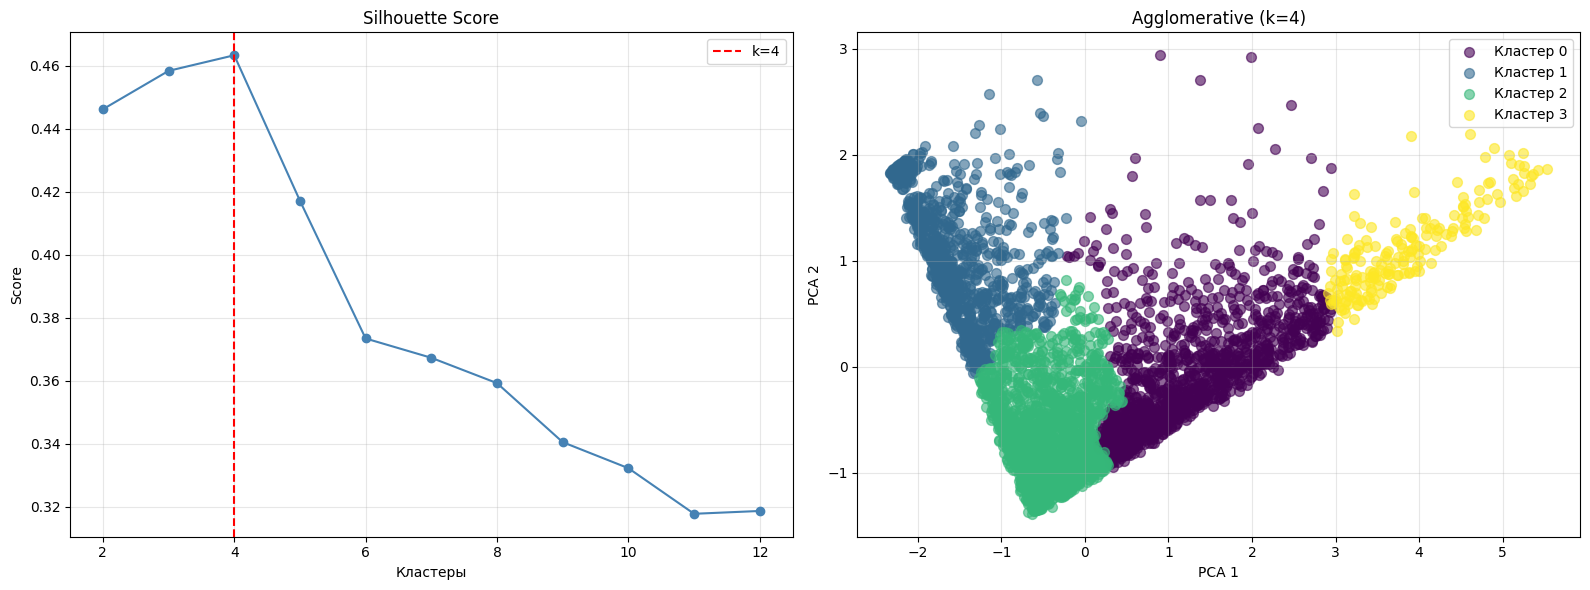

In [146]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График silhouette
axes[0].plot(range(min_k, max_k+1), silhouette_scores_agg, 'o-', color='steelblue')
axes[0].axvline(best_k_agg, color='red', linestyle='--', label=f'k={best_k_agg}')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Кластеры')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График кластеров
colors = plt.cm.viridis(np.linspace(0, 1, best_k_agg))
for i in range(best_k_agg):
    axes[1].scatter(X_preprocessed[cluster_labels == i, 0], 
                   X_preprocessed[cluster_labels == i, 1], 
                   c=[colors[i]], label=f'Кластер {i}', s=50, alpha=0.6)
axes[1].set_title(f'Agglomerative (k={best_k_agg})')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/agg_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 3. GMM

In [147]:
# Расчет silhouette scores
min_k, max_k = 2, 12
silhouette_scores_gmm = []
for k in range(min_k, max_k + 1):
    labels = GaussianMixture(n_components=k, random_state=42).fit_predict(X_preprocessed)
    silhouette_scores_gmm.append(silhouette_score(X_preprocessed, labels))

best_k_gmm = np.argmax(silhouette_scores_gmm) + min_k

# Обучение лучшей модели
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
cluster_labels = gmm.fit_predict(X_preprocessed)
score_gmm = silhouette_score(X_preprocessed, cluster_labels)

print(f"Оптимальное k: {best_k_gmm}, Silhouette Score: {score_gmm:.4f}")


Оптимальное k: 3, Silhouette Score: 0.4358


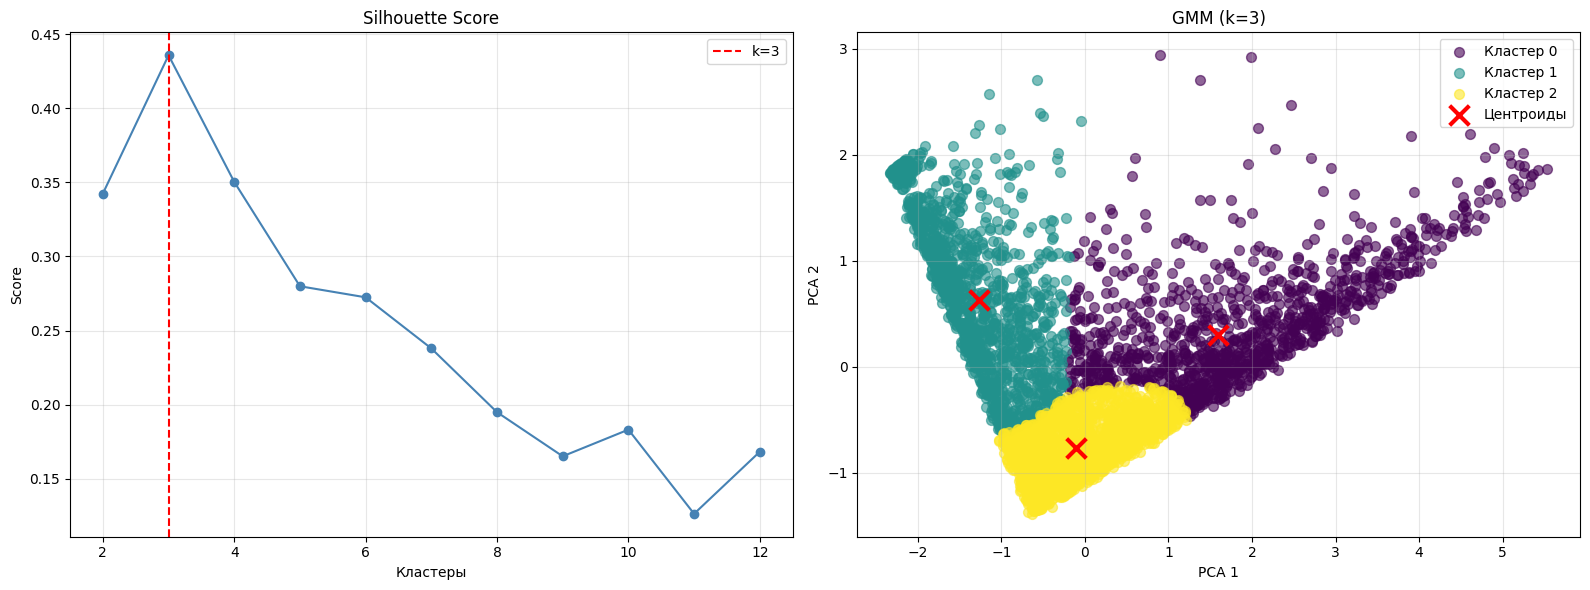

In [148]:

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График silhouette
axes[0].plot(range(min_k, max_k+1), silhouette_scores_gmm, 'o-', color='steelblue')
axes[0].axvline(best_k_gmm, color='red', linestyle='--', label=f'k={best_k_gmm}')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Кластеры')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# График кластеров
colors = plt.cm.viridis(np.linspace(0, 1, best_k_gmm))
for i in range(best_k_gmm):
    axes[1].scatter(X_preprocessed[cluster_labels == i, 0], 
                   X_preprocessed[cluster_labels == i, 1], 
                   c=[colors[i]], label=f'Кластер {i}', s=50, alpha=0.6)
# Центроиды
axes[1].scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
               c='red', marker='x', s=200, linewidths=3, label='Центроиды', zorder=10)
axes[1].set_title(f'GMM (k={best_k_gmm})')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/gmm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [149]:
# Сравнение методов
print(f"KMeans (k={best_k_km}): {score_kmeans:.4f}")
print(f"Agglomerative (k={best_k_agg}): {score_linkage:.4f}")
print(f"GMM (k={best_k_gmm}): {score_gmm:.4f}")

# Лучший метод
methods = {'KMeans': score_kmeans, 'Agglomerative': score_linkage, 'GMM': score_gmm}
best_overall = max(methods, key=methods.get)
print(f"\nЛучший: {best_overall} ({methods[best_overall]:.4f})")

KMeans (k=3): 0.5242
Agglomerative (k=4): 0.4633
GMM (k=3): 0.4358

Лучший: KMeans (0.5242)


In [150]:
# Обучение лучшей модели и получение предсказаний
best_n_clusters = best_k_km
best_model = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
# Получаем предсказания меток кластеров
cluster_labels = best_model.fit_predict(X_preprocessed)
# Добавляем метки кластеров в RFM-таблицу
rfm_table['Cluster'] = cluster_labels

print("Распределение клиентов по кластерам:")
print(rfm_table['Cluster'].value_counts().sort_index())

Распределение клиентов по кластерам:
Cluster
0    2267
1     776
2    1001
Name: count, dtype: int64


### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

In [151]:
# Создаем маппинг для переименования кластеров
cluster_names = {
    0: 'Перспективные клиенты (Кластер 0)',
    1: 'Лояльные клиенты (Кластер 1)',
    2: 'Спящие клиенты (Кластер 2)'
}

# Создаем копию данных с переименованными кластерами
rfm_table_named = rfm_table.reset_index().copy()
rfm_table_named['Cluster_Name'] = rfm_table_named['Cluster'].map(cluster_names)

# Создаем интерактивный 3D-график
fig = px.scatter_3d(
    rfm_table_named,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster_Name',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    opacity=0.6,
    title=f'3D-визуализация кластеров клиентов ({best_overall}, n={best_n_clusters})',
    labels={
        'Recency': 'Recency (дней с последней покупки)',
        'Frequency': 'Frequency (количество заказов)',
        'Monetary': 'Monetary (сумма покупок)',
        'Cluster_Name': 'Сегмент клиентов'
    },
    hover_data=['CustomerID', 'Cluster'],
    category_orders={'Cluster_Name': ['Лояльные клиенты', 'Перспективные клиенты', 'Спящие клиенты']}
)

fig.update_layout(
    scene=dict(
        xaxis_title='Recency (дней с последней покупки)',
        yaxis_title='Frequency (количество заказов)',
        zaxis_title='Monetary (сумма покупок)'
    ),
    width=1000,
    height=800,
    legend=dict(
        title_text='Сегменты клиентов',
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)
# fig.write_html('visualizations/3d_clusters.html')
fig.write_image('visualizations/3d_clusters.png', engine="kaleido")
fig.show()

In [152]:
rfm_table.groupby('Cluster').mean().round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,51.13,2.33,660.20
1,31.94,7.07,2658.05
2,253.28,1.41,386.70


#### Анализ 3D-визуализации кластеров и качества кластеризации

KMeans — лучший метод по Silhouette Score. Количество кластеров — 3. Best Score — 0.5242. 

Получено три кластера:
- **Кластер 1** - Лояльные клиенты. 

- **Кластер 0** - Перспективные клиенты. 

- **Кластер 2**- Спящие клиенты. 

Кластеры легко интерпретируются в терминах маркетинговой сегментации. Хорошее качество разделения кластеров (Silhouette Score 0.5242). 

На 3D-диаграмме Кластер 1 (Лояльные) образует плотную группу с высокими значениями Frequency и Monetary и низким Recency. Кластер 0 (Перспективные) занимает промежуточное положение между лояльными и спящими клиентами. Кластер 2 (Спящие) выделяется очень высоким Recency и низкими значениями Frequency и Monetary. Однако Silhouette Score, равный 0.5242, указывает на наличие некоторого пересечения между кластерами. Что может быть связано с понижением размерности до 2 компонент и удалением выбросов.

Таким образом, кластеризация проведена успешно и позволила выделить три четких сегмента клиентов с различной покупательской активностью. 

#### 3.2.2. Построение профиля кластеров

Далее составьте так называемый профиль кластеров. Для этого вам необходимо вернуться от декомпозированных данных (если вы производили понижение размерности) к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, давайте познакомимся с одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На этой диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие этому кластеру, в большей степени увлекаются музыкой (Music), а в меньшей — программированием (Programm).

В модуле `graph_objects` библиотеки `plotly` есть встроенная функция `Scatterpolar`, которая позволяет построить полярную диаграмму. На основе этой функции мы подготовили для вас функцию `plot_cluster_profile()`, которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У неё есть два параметра: `grouped_data` — сгруппированные по кластерам характеристики объектов (клиентов), `n_clusters` — количество кластеров.

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в функцию `plot_cluster_profile()`.


In [160]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    # fig.write_html('visualizations/plot_clusters.html')
    fig.write_image('visualizations/plot_clusters.svg', engine="kaleido")
    fig.show()

Теперь у вас есть удобный инструмент для анализа профиля кластеров. Воспользуйтесь им, чтобы проинтерпретировать результаты, полученные на предыдущем шаге.

In [161]:
data_rfm_group = rfm_table.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
data_rfm_group = data_rfm_group.reset_index(drop=True)
print(data_rfm_group)

      Recency  Frequency     Monetary
0   51.127481   2.329069   660.199815
1   31.943299   7.068299  2658.049253
2  253.283716   1.405594   386.704366


In [155]:
scaler = preprocessing.MinMaxScaler()
data_rfm_group_scaler = pd.DataFrame(scaler.fit_transform(data_rfm_group), columns=data_rfm_group.columns)
data_rfm_group_scaler

,Recency,Frequency,Monetary
0,0.086673,0.16308,0.120411
1,0.000000,1.00000,1.000000
2,1.000000,0.00000,0.000000


In [162]:
plot_cluster_profile(data_rfm_group, 3)

# Интерпретация полученных кластеров

Полярная диаграмма наглядно демонстрирует различия между тремя сегментами клиентов.

На полярной диаграмме хорошо видно, что:

- Многоугольник Кластера 1 самый большой и вытянут в сторону Frequency и Monetary.
- Многоугольник Кластера 0 имеет более сбалансированную, но меньшую форму.
- Многоугольник Кластера 2 самый маленький и вытянут в сторону Recency.

Многоугольники кластеров не пересекаются или пересекаются минимально, что подтверждает качественное разделение сегментов и корректность проведённой кластеризации.

Каждый кластер имеет уникальный профиль по всем трем RFM-характеристикам:

**Кластер 1**: Лояльные клиенты. Покупали в среднем 31.94 дня назад. Частота покупок в среднем — 7.07 заказов. Средняя сумма трат — 2658.05 фунтов. Это самые ценные клиенты компании. Покупают часто, тратят много, последняя покупка была около месяца назад. Это ядро клиентской базы.

**Кластер 0**: Перспективные клиенты. Покупали в среднем 51.13 дня назад. Частота покупок в среднем — 2.33 заказа. Средняя сумма трат — 660.20 фунтов. Клиенты с потенциалом роста. Покупают регулярно, но реже и на меньшие суммы, чем VIP-клиенты. Можно перевести в сегмент лояльных клиентов.

**Кластер 2**: Спящие клиенты. Покупали в среднем 253.28 дня назад. Частота покупок в среднем — 1.41 заказа. Средняя сумма трат — 386.70 фунтов. Клиенты, которые практически перестали совершать покупки. Высокий риск полной потери клиента.

Основные приоритеты по работе с клиентами:

- Для лояльных клиентов (Кластер 1) основные приоритеты: удержание и укрепление отношений, предотвращение оттока, увеличение общей прибыли от взаимодействия с клиентом.

- Для перспективных клиентов (Кластер 0) основные приоритеты: перевод в сегмент VIP, увеличение частоты покупок, рост среднего чека.

- Для спящих клиентов (Кластер 2) основные приоритеты: реактивация наиболее перспективных, определение причин оттока, минимизация потерь.

Таким образом кластеры хорошо разделены по всем трем RFM-характеристикам, что подтверждает качество кластеризации. Каждый сегмент требует индивидуального подхода и специфической маркетинговой стратегии. Разделение клиентов на сегменты позволяет компании оптимизировать маркетинговый бюджет и сосредоточить усилия на наиболее перспективных направлениях.

## 5. Выводы и оформление работы

В рамках проекта решена задача сегментации клиентов онлайн-магазина подарков на основе анализа транзакций за 2010–2011 годы.

**Выполненные этапы**

1. Предобработка данных: очистка от пропусков, дубликатов, учёт возвратов
2. Разведывательный анализ: выявлена сезонность (пик в ноябре), основная выручка из Великобритании
3. RFM-анализ и кластеризация: метод KMeans с 3 кластерами (Silhouette Score 0.5242)

**Найденные сегменты клиентов**
- Лояльные клиенты: cамые ценные клиенты: покупают часто, тратят больше всех, последняя покупка около месяца назад.
- Перспективные клиенты: клиенты с потенциалом роста: умеренная активность, могут быть переведены в сегмент лояльные клиенты. 
- Спящие клиенты: клиенты с высоким риском оттока: давно не покупали (более 8 месяцев), низкая активность.

**Рекомендации**

- Лояльные клиенты: удержание и увеличение общей прибыли от взаимодействия с клиентом.
- Перспективные клиенты: перевод в сегмент лояльных.
- Спящие клиенты: реактивация.

**Вывод**

Выделены три чётких сегмента клиентов с различной покупательской активностью. Silhouette Score 0.5242 подтверждает хорошее качество кластеризации. Полученные результаты позволяют компании оптимизировать маркетинговый бюджет и сосредоточиться на наиболее перспективных направлениях.